In [9]:
import pandas as pd
import os
import altair as alt
import numpy as np
import plotnine as pt
import geopandas as gpd
import plotly

In [10]:
os.chdir('/Users/trishapunamiya/Desktop/LSE/Data Viz/Project/Raw Data')

In [20]:
import pandas as pd

# Load data for all three years
years = [2022, 2023, 2024]
all_data = []

for year in years:
    # Load enrollment data
    df_enr = pd.read_csv(f'{year}/100_enr1.csv')
    
    # Load school profile data
    df_profile = pd.read_csv(f'{year}/100_prof1.csv')
    
    # Merge on pseudocode
    df_merged = df_enr.merge(
        df_profile[['pseudocode', 'state', 'district', 'rural_urban']], 
        on='pseudocode', 
        how='left'
    )
    
    # Add year column
    df_merged['year'] = year
    
    # Append to list
    all_data.append(df_merged)

# Combine all years into one dataframe
df_merged = pd.concat(all_data, ignore_index=True)

Gender Gap by State

In [22]:
import pandas as pd

# Function to normalize state names
def normalize_and_map_state(state_name):
    """Convert state name to standardized format"""
    if pd.isna(state_name):
        return None
    
    # Normalize to uppercase for matching
    normalized = str(state_name).strip().upper()
    
    # Mapping dictionary (all uppercase keys)
    mapping = {
        "ANDAMAN & NICOBAR ISLANDS": "Andaman and Nicobar",
        "ANDAMAN AND NICOBAR ISLANDS": "Andaman and Nicobar",
        "ANDHRA PRADESH": "Andhra Pradesh",
        "ARUNACHAL PRADESH": "Arunachal Pradesh",
        "ASSAM": "Assam",
        "BIHAR": "Bihar",
        "CHANDIGARH": "Chandigarh",
        "CHHATTISGARH": "Chhattisgarh",
        "DADRA & NAGAR HAVELI AND DAMAN & DIU": "Dadra and Nagar Haveli and Daman and Diu",
        "DADRA AND NAGAR HAVELI AND DAMAN AND DIU": "Dadra and Nagar Haveli and Daman and Diu",
        "DELHI": "Delhi",
        "GOA": "Goa",
        "GUJARAT": "Gujarat",
        "HARYANA": "Haryana",
        "HIMACHAL PRADESH": "Himachal Pradesh",
        "JAMMU & KASHMIR": "Jammu and Kashmir",
        "JAMMU AND KASHMIR": "Jammu and Kashmir",
        "JHARKHAND": "Jharkhand",
        "KARNATAKA": "Karnataka",
        "KERALA": "Kerala",
        "LADAKH": "Ladakh",
        "LAKSHADWEEP": "Lakshadweep",
        "MADHYA PRADESH": "Madhya Pradesh",
        "MAHARASHTRA": "Maharashtra",
        "MANIPUR": "Manipur",
        "MEGHALAYA": "Meghalaya",
        "MIZORAM": "Mizoram",
        "NAGALAND": "Nagaland",
        "ODISHA": "Orissa",
        "PUDUCHERRY": "Puducherry",
        "PUNJAB": "Punjab",
        "RAJASTHAN": "Rajasthan",
        "SIKKIM": "Sikkim",
        "TAMIL NADU": "Tamil Nadu",
        "TAMILNADU": "Tamil Nadu",
        "TELANGANA": "Telangana",
        "TRIPURA": "Tripura",
        "UTTAR PRADESH": "Uttar Pradesh",
        "UTTARAKHAND": "Uttarakhand",
        "WEST BENGAL": "West Bengal"
    }
    
    return mapping.get(normalized, None)

# Load data for all three years
years = [2022, 2023, 2024]
all_data = []

for year in years:
    print(f"\nProcessing year {year}...")
    
    # Load enrollment data
    df_enr = pd.read_csv(f'{year}/100_enr1.csv')
    
    # Load school profile data
    df_profile = pd.read_csv(f'{year}/100_prof1.csv')
    
    # Merge on pseudocode
    df_merged = df_enr.merge(
        df_profile[['pseudocode', 'state', 'district', 'rural_urban']], 
        on='pseudocode', 
        how='left'
    )
    
    # Add year column
    df_merged['year'] = year
    
    # Append to list
    all_data.append(df_merged)

# Combine all years into one dataframe
df_merged = pd.concat(all_data, ignore_index=True)

# Class columns for boys and girls
boy_cols = ['cpp_b', 'c1_b', 'c2_b', 'c3_b', 'c4_b', 'c5_b', 'c6_b', 
'c7_b', 'c8_b', 'c9_b', 'c10_b', 'c11_b', 'c12_b']
girl_cols = ['cpp_g', 'c1_g', 'c2_g', 'c3_g', 'c4_g', 'c5_g', 'c6_g', 
'c7_g', 'c8_g', 'c9_g', 'c10_g', 'c11_g', 'c12_g']

# Calculate total boys and girls for each row
df_merged['total_boys'] = df_merged[boy_cols].sum(axis=1)
df_merged['total_girls'] = df_merged[girl_cols].sum(axis=1)
df_merged['total_students'] = df_merged['total_boys'] + df_merged['total_girls']

# Store original state names before normalization
df_merged['original_state'] = df_merged['state']

# Normalize state names using the function
df_merged['state'] = df_merged['state'].apply(normalize_and_map_state)

# Check for unmapped states
unmapped = df_merged[df_merged['state'].isna()]
if len(unmapped) > 0:
    print(f"\nWARNING: {len(unmapped)} rows with unmapped states!")
    print("Unmapped state names:")
    print(unmapped['original_state'].value_counts())

# Remove rows with unmapped states
df_merged = df_merged.dropna(subset=['state'])

# Group by state AND year
state_gender = df_merged.groupby(['state', 'year']).agg({
    'total_boys': 'sum',
    'total_girls': 'sum'
}).reset_index()

# Calculate gender gap
state_gender['total_enrollment'] = state_gender['total_boys'] + state_gender['total_girls']
state_gender['girls_percentage'] = (state_gender['total_girls'] / state_gender['total_enrollment']) * 100
state_gender['boys_percentage'] = (state_gender['total_boys'] / state_gender['total_enrollment']) * 100
state_gender['gender_gap'] = state_gender['girls_percentage'] - state_gender['boys_percentage']

# Sort by year and gender gap
state_gender = state_gender.sort_values(['year', 'gender_gap']).reset_index(drop=True)

# Save
state_gender.to_json('/Users/trishapunamiya/tpunamiya.github.io-4/charts/gender_gap_by_state.json', orient='records', indent=2)
print("\n✓ Multi-year data saved with normalized state names")
print(f"Total records: {len(state_gender)}")
print(f"Years: {sorted(state_gender['year'].unique())}")
print(f"States: {sorted(state_gender['state'].unique())}")
print("\nSample data:")
print(state_gender.head(10))


Processing year 2022...

Processing year 2023...

Processing year 2024...

✓ Multi-year data saved with normalized state names
Total records: 108
Years: [2022, 2023, 2024]
States: ['Andaman and Nicobar', 'Andhra Pradesh', 'Arunachal Pradesh', 'Assam', 'Bihar', 'Chandigarh', 'Chhattisgarh', 'Dadra and Nagar Haveli and Daman and Diu', 'Delhi', 'Goa', 'Gujarat', 'Haryana', 'Himachal Pradesh', 'Jammu and Kashmir', 'Jharkhand', 'Karnataka', 'Kerala', 'Ladakh', 'Lakshadweep', 'Madhya Pradesh', 'Maharashtra', 'Manipur', 'Meghalaya', 'Mizoram', 'Nagaland', 'Orissa', 'Puducherry', 'Punjab', 'Rajasthan', 'Sikkim', 'Tamil Nadu', 'Telangana', 'Tripura', 'Uttar Pradesh', 'Uttarakhand', 'West Bengal']

Sample data:
                                      state  year  total_boys  total_girls  \
0                                   Haryana  2022     3721649      3064647   
1                                    Punjab  2022     5362631      4534360   
2                                Chandigarh  2022     

# Bubble Chart - Student/Teacher

In [5]:
# Load teacher data
df_teacher = pd.read_csv('2024/100_tch.csv')

# Merge teacher data with state info on pseudocode
df_teacher_merged = df_teacher.merge(
    df_profile[['pseudocode', 'state']], 
    on='pseudocode', 
    how='left'
)

# Aggregate teachers by state
state_teachers = df_teacher_merged.groupby('state').agg({
    'total_tch': 'sum'
}).reset_index()

# Aggregate schools and students by state
schools_per_state = df_merged.groupby('state').agg({
    'pseudocode': 'nunique',  # Count unique schools
    'total_students': 'sum'
}).reset_index()

# Rename pseudocode to num_schools (DO THIS BEFORE MERGING)
schools_per_state.rename(columns={'pseudocode': 'num_schools'}, inplace=True)

# Calculate average students per school
schools_per_state['avg_students_per_school'] = schools_per_state['total_students'] / schools_per_state['num_schools']

# Merge enrollment and teacher data
state_data = schools_per_state.merge(state_teachers, on='state')

# Calculate student-teacher ratio
state_data['student_teacher_ratio'] = state_data['total_students'] / state_data['total_tch']

# Add region classification
def classify_region(state):
    """Classify Indian states into regions"""
    north = ['JAMMU & KASHMIR', 'HIMACHAL PRADESH', 'PUNJAB', 'CHANDIGARH', 
             'UTTARAKHAND', 'HARYANA', 'DELHI', 'RAJASTHAN']
    east_central = ['UTTAR PRADESH', 'BIHAR', 'JHARKHAND', 'WEST BENGAL', 
                    'ODISHA', 'CHHATTISGARH']
    west = ['MADHYA PRADESH', 'GUJARAT', 'MAHARASHTRA', 'GOA', 
            'DADRA & NAGAR HAVELI AND DAMAN & DIU', 'DAMAN & DIU', 
            'DADRA AND NAGAR HAVELI']
    south = ['ANDHRA PRADESH', 'KARNATAKA', 'KERALA', 'TAMIL NADU', 
             'TELANGANA', 'PUDUCHERRY', 'LAKSHADWEEP', 
             'ANDAMAN & NICOBAR ISLANDS', 'ANDAMAN AND NICOBAR ISLANDS']
    northeast = ['ARUNACHAL PRADESH', 'ASSAM', 'MANIPUR', 'MEGHALAYA', 
                 'MIZORAM', 'NAGALAND', 'SIKKIM', 'TRIPURA']
    
    state_upper = state.upper()
    if state_upper in north:
        return 'North'
    elif state_upper in east_central:
        return 'East/Central'
    elif state_upper in west:
        return 'West'
    elif state_upper in south:
        return 'South'
    elif state_upper in northeast:
        return 'Northeast'
    else:
        return 'Other'

state_data['region'] = state_data['state'].apply(classify_region)

print(state_data[['state', 'num_schools', 'avg_students_per_school', 'student_teacher_ratio', 'region']])

# Save to JSON
#state_data.to_json('student_teacher_bubble.json', orient='records', indent=2)

print("\n✓ Data saved!")
print(f"\nAvg students per school range: {state_data['avg_students_per_school'].min():.0f} to {state_data['avg_students_per_school'].max():.0f}")

                                   state  num_schools  \
0              ANDAMAN & NICOBAR ISLANDS          408   
1                         ANDHRA PRADESH        61316   
2                      ARUNACHAL PRADESH         3208   
3                                  ASSAM        55283   
4                                  BIHAR        94334   
5                             CHANDIGARH          207   
6                           CHHATTISGARH        56802   
7   DADRA & NAGAR HAVELI AND DAMAN & DIU          433   
8                                  DELHI         5556   
9                                    GOA         1479   
10                               GUJARAT        53292   
11                               HARYANA        23494   
12                      HIMACHAL PRADESH        17330   
13                       JAMMU & KASHMIR        24046   
14                             JHARKHAND        44269   
15                             KARNATAKA        74589   
16                             

In [12]:
import pandas as pd
import altair as alt

# Assuming df_merged has enrollment data

# Define class columns
class_levels = ['cpp', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12']
class_labels = ['Pre-Primary', 'Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5', 
                'Class 6', 'Class 7', 'Class 8', 'Class 9', 'Class 10', 'Class 11', 'Class 12']

# Aggregate by class level
dropout_data = []

for i, class_level in enumerate(class_levels):
    boys_col = f'{class_level}_b'
    girls_col = f'{class_level}_g'
    
    total_boys = df_merged[boys_col].sum()
    total_girls = df_merged[girls_col].sum()
    
    dropout_data.append({
        'Class': class_labels[i],
        'Gender': 'Boys',
        'Enrollment': total_boys,
        'Class_Order': i
    })
    
    dropout_data.append({
        'Class': class_labels[i],
        'Gender': 'Girls',
        'Enrollment': total_girls,
        'Class_Order': i
    })

df_dropout = pd.DataFrame(dropout_data)

# Create the chart with Altair
chart = alt.Chart(df_dropout).mark_line(point=True, strokeWidth=3).encode(
    x=alt.X('Class:N', 
            axis=alt.Axis(title=None, labelAngle=-45),
            sort=class_labels),
    y=alt.Y('Enrollment:Q',
            axis=alt.Axis(title='Number of Students Enrolled', format='~s')),
    color=alt.Color('Gender:N',
                    scale=alt.Scale(domain=['Boys', 'Girls'], 
                                   range=['#5499C7', '#E74C3C']),
                    legend=alt.Legend(title='Gender')),
    tooltip=['Class', 'Gender', alt.Tooltip('Enrollment:Q', format=',')]
).properties(
    width=650,
    height=400,
    title={
        "text": "Student Enrollment Drop-off by Class Level",
        "subtitle": "All-India enrollment from Pre-Primary through Class 12 | Data: UDISE+ India",
        "fontSize": 16,
        "subtitleFontSize": 12
    }
)

# Display the chart
chart.show()

# Save as JSON for Vega-Lite

alt.Chart(...)

In [13]:
# List of years to process
years = [2022, 2023]

# Store all data
all_years_data = []

for year in years:
    print(f"Processing {year}...")
    
    # Load enrollment data for this year
    enr_file = f'/Users/trishapunamiya/Desktop/LSE/Data Viz/Project/Raw Data/{year}/100_enr1.csv'
    df_enr = pd.read_csv(enr_file)
    
    # Load profile data for this year to get state info
    profile_file = f'/Users/trishapunamiya/Desktop/LSE/Data Viz/Project/Raw Data/{year}/100_prof1.csv'  # Adjust filename if different
    df_profile = pd.read_csv(profile_file)
    
    # Merge
    df_merged_year = df_enr.merge(df_profile[['pseudocode', 'state']], on='pseudocode', how='left')
    
    # Add year column
    df_merged_year['year'] = year
    
    # Append to list
    all_years_data.append(df_merged_year)
    
    print(f"  ✓ Loaded {len(df_merged_year):,} rows for {year}")

# Combine all years
df_all_years = pd.concat(all_years_data, ignore_index=True)

Processing 2022...
  ✓ Loaded 7,695,344 rows for 2022
Processing 2023...
  ✓ Loaded 8,234,734 rows for 2023


### Loading 2021-2024 Enrolment and School Profile Data

In [14]:
years = [2022, 2023, 2024]
all_years_data = []

for year in years:
    print(f"\n=== Processing {year} ===")
    
    # Load enrollment data for this year
    enr_file = f'/Users/trishapunamiya/Desktop/LSE/Data Viz/Project/Raw Data/{year}/100_enr1.csv'  # Adjust path as needed
    df_enr = pd.read_csv(enr_file)
    print(f"Loaded enrollment: {len(df_enr):,} rows")
    
    # Load profile data for this year
    profile_file = f'/Users/trishapunamiya/Desktop/LSE/Data Viz/Project/Raw Data/{year}/100_prof1.csv'
    df_profile = pd.read_csv(profile_file)
    print(f"Loaded profile: {len(df_profile):,} rows")
    
    # Merge
    df_merged_year = df_enr.merge(df_profile[['pseudocode', 'state']], on='pseudocode', how='left')
    print(f"After merge: {len(df_merged_year):,} rows")
    
    # Add year column
    df_merged_year['year'] = year
    
    # Append to list
    all_years_data.append(df_merged_year)
    print(f"✓ Added {year} to list (list now has {len(all_years_data)} dataframes)")

# 2021 data
profile_2021 = pd.read_csv('/Users/trishapunamiya/Desktop/LSE/Data Viz/Project/Raw Data/2021/nationalProfile_1.csv')
enroll_2021 = pd.read_csv('/Users/trishapunamiya/Desktop/LSE/Data Viz/Project/Raw Data/2021/22-100_enr1/nationalEnrol1.csv')
df_merged_2021 = enroll_2021.merge(profile_2021[['psuedocode', 'state']], on='psuedocode', how='left')
df_merged_2021['year'] = 2021
#all_years_data.append(df_merged_2021)

# Combine all years
df_all = pd.concat(all_years_data, ignore_index=True)

print(f"\n=== FINAL RESULT ===")
print(f"Total rows: {len(df_all):,}")
print(f"Years in combined data: {df_all['year'].unique()}")



=== Processing 2022 ===


ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [ ]:
# Cleaning of the merged dataset
df_all['state'] = df_all['state'].astype(str).str.strip().str.title()

# changing Tamilnadu to Tamil Nadu
df_all['state'] = df_all['state'].replace('Tamilnadu', 'Tamil Nadu')     


In [ ]:
# -------------------------------------------------------
# STEP 1 — Prepare funnel data for all years and states
# -------------------------------------------------------
class_levels = ['c1','c2','c3','c4','c5','c6','c7','c8','c9','c10','c11','c12']
class_labels = ['Class 1','Class 2','Class 3','Class 4','Class 5','Class 6',
                'Class 7','Class 8','Class 9','Class 10','Class 11','Class 12']

records = []

for year in sorted(df_all['year'].unique()):
    df_year = df_all[df_all['year'] == year]
    
    # Aggregate All-India
    for i, class_level in enumerate(class_levels):
        boys_col = f'{class_level}_b'
        girls_col = f'{class_level}_g'
        total_boys = df_year[boys_col].sum()
        total_girls = df_year[girls_col].sum()
        records.append({'Class': class_labels[i], 'Gender': 'Boys', 'Enrollment': -total_boys,
                        'Year': year, 'State': 'All India'})
        records.append({'Class': class_labels[i], 'Gender': 'Girls', 'Enrollment': total_girls,
                        'Year': year, 'State': 'All India'})

    # Aggregate by state
    for state in df_year['state'].unique():
        df_state = df_year[df_year['state'] == state]
        for i, class_level in enumerate(class_levels):
            boys_col = f'{class_level}_b'
            girls_col = f'{class_level}_g'
            total_boys = df_state[boys_col].sum()
            total_girls = df_state[girls_col].sum()
            records.append({'Class': class_labels[i], 'Gender': 'Boys', 'Enrollment': -total_boys,
                            'Year': year, 'State': state})
            records.append({'Class': class_labels[i], 'Gender': 'Girls', 'Enrollment': total_girls,
                            'Year': year, 'State': state})

df_dropout = pd.DataFrame(records)
df_dropout['Class'] = pd.Categorical(df_dropout['Class'], categories=class_labels[::-1], ordered=True)

# -------------------------------------------------------
# STEP 2 — Precompute max enrollment per state (RUN THIS FIRST)
# -------------------------------------------------------
state_max = df_dropout.groupby('State')['Enrollment'].apply(
    lambda x: max(abs(x.min()), abs(x.max()))
).reset_index()
state_max = state_max.rename(columns={'Enrollment': 'max_enrollment'})
df_dropout = df_dropout.merge(state_max, on='State', how='left')

# -------------------------------------------------------
# STEP 3 — Altair interactive funnel chart (MATCHED THEME)
# -------------------------------------------------------

year_param = alt.param(
    name='YearParam',
    value=int(df_dropout['Year'].min()),
    bind=alt.binding_range(
        min=int(df_dropout['Year'].min()),
        max=int(df_dropout['Year'].max()),
        step=1,
        name='Year: '
    )
)

state_param = alt.param(
    name='StateParam',
    value='All India',
    bind=alt.binding_select(
        options=sorted(df_dropout['State'].unique()),
        name='State: '
    )
)

# Create a dummy dataset for scale anchors
scale_anchors = []
for state in df_dropout['State'].unique():
    max_val = df_dropout[df_dropout['State'] == state]['max_enrollment'].iloc[0]
    scale_anchors.append({'State': state, 'anchor_value': -max_val})
    scale_anchors.append({'State': state, 'anchor_value': max_val})

df_anchors = pd.DataFrame(scale_anchors)

# Base layer - invisible points to set scale
base = alt.Chart(df_anchors).transform_filter(
    alt.datum.State == state_param
).mark_point(opacity=0).encode(
    x='anchor_value:Q'
).add_params(state_param)

# Main chart layer
bars = alt.Chart(df_dropout).transform_filter(
    alt.datum.State == state_param
).transform_filter(
    alt.datum.Year == year_param
).mark_bar().encode(
    y=alt.Y('Class:N', 
        sort=class_labels[::-1], 
        title=None,
        axis=alt.Axis(labelPadding=10, labelFontSize=12)
    ),
    x=alt.X('Enrollment:Q',
        axis=alt.Axis(
            title='Number of Students (thousands)',
            labelExpr="abs(datum.value)/1000",
            grid=False,
            tickCount=8,
            labelFontSize=12,
            titleFontSize=12
        )
    ),
    color=alt.Color('Gender:N', 
        scale=alt.Scale(domain=['Boys','Girls'], range=['#77ba99','#ba7798']),
        legend=alt.Legend(
            orient='right',
            titleFontSize=12,
            labelFontSize=12,
            symbolSize=200
        )
    )
).add_params(year_param)

# Add a center line at zero
rule = alt.Chart(pd.DataFrame({'x': [0]})).mark_rule(
    color='gray',
    strokeWidth=1.5,
    strokeDash=[5, 5]
).encode(x='x:Q')

# Layer them together
chart = alt.layer(base, bars, rule).resolve_scale(
    x='shared'
).properties(
    width=500,
    height=350,
    title={
        'text': 'Education Pipeline: Enrollment by Class and Gender',
        'subtitle': 'Note: Since 2021 data is only available for 25 of 37 states, it is excluded from this chart',
        'fontSize': 16,
        'subtitleFontSize': 12,
        'subtitleColor': '#666',
        'anchor': 'start'
    }
).configure_view(
    strokeWidth=1, stroke='gray'
).configure_axis(
    domainWidth=1
)

chart

alt.LayerChart(...)

In [ ]:
chart.save('/Users/trishapunamiya/tpunamiya.github.io-4/education_dropout_byStateGender.json')

In [ ]:
# Check states with data in 2021
df_2021 = df_dropout[df_dropout['Year'] == 2021]

print(f"Total states in dataset: {df_dropout['State'].nunique()}")
print(f"States with data in 2021: {df_2021['State'].nunique()}")
print(f"\nTotal rows for 2021: {len(df_2021)}")

# See which states have data in 2021
states_2021 = sorted(df_2021['State'].unique())
print(f"\nStates with 2021 data:")
for state in states_2021:
    state_data = df_2021[df_2021['State'] == state]
    total_enrollment = state_data['Enrollment'].abs().sum()
    print(f"  {state}: {len(state_data)} rows, {total_enrollment:,.0f} total enrollment")

# Check which states are missing 2021 data
all_states = set(df_dropout['State'].unique())
states_with_2021 = set(df_2021['State'].unique())
missing_2021 = sorted(all_states - states_with_2021)

if missing_2021:
    print(f"\nStates MISSING 2021 data ({len(missing_2021)}):")
    for state in missing_2021:
        print(f"  {state}")

# Also check what years are available
print(f"\nAvailable years: {sorted(df_dropout['Year'].unique())}")

# print list of states with data in 2024
df_2024 = df_dropout[df_dropout['Year'] == 2024]
states_2024 = sorted(df_2024['State'].unique())

Total states in dataset: 37
States with data in 2021: 25

Total rows for 2021: 600

States with 2021 data:
  All India: 24 rows, 126,765,763 total enrollment
  Andaman & Nicobar Islands: 24 rows, 151,705 total enrollment
  Arunachal Pradesh: 24 rows, 733,159 total enrollment
  Chandigarh: 24 rows, 525,753 total enrollment
  Chhattisgarh: 24 rows, 14,387,235 total enrollment
  Dadra & Nagar Haveli And Daman & Diu: 24 rows, 261,430 total enrollment
  Delhi: 24 rows, 8,829,947 total enrollment
  Goa: 24 rows, 639,529 total enrollment
  Gujarat: 24 rows, 22,608,909 total enrollment
  Haryana: 24 rows, 11,098,194 total enrollment
  Himachal Pradesh: 24 rows, 2,450,679 total enrollment
  Jammu & Kashmir: 24 rows, 6,716,730 total enrollment
  Jharkhand: 24 rows, 17,403,082 total enrollment
  Kerala: 24 rows, 15,472,681 total enrollment
  Ladakh: 24 rows, 142,935 total enrollment
  Lakshadweep: 24 rows, 36,275 total enrollment
  Manipur: 24 rows, 1,461,657 total enrollment
  Meghalaya: 24 rows

In [ ]:
# Create a line chart from 2021-2024 showing total enrollment over time
line_data = df_all.groupby(['year']).agg({
    'cpp_b': 'sum', 'cpp_g': 'sum',
    'c1_b': 'sum', 'c1_g': 'sum',
    'c2_b': 'sum', 'c2_g': 'sum',
    'c3_b': 'sum', 'c3_g': 'sum',
    'c4_b': 'sum', 'c4_g': 'sum',
    'c5_b': 'sum', 'c5_g': 'sum',
    'c6_b': 'sum', 'c6_g': 'sum',
    'c7_b': 'sum', 'c7_g': 'sum',
    'c8_b': 'sum', 'c8_g': 'sum',
    'c9_b': 'sum', 'c9_g': 'sum',
    'c10_b': 'sum', 'c10_g': 'sum',
    'c11_b': 'sum', 'c11_g': 'sum',
    'c12_b': 'sum', 'c12_g': 'sum'
}).reset_index()
line_data['total_enrollment'] = line_data.sum(axis=1) - line_data['year']
line_data = line_data[['year', 'total_enrollment']]

## Cholorepth Map

In [ ]:
import geopandas as gpd

# Read the shapefile
gdf = gpd.read_file('/Users/trishapunamiya/Desktop/LSE/Data Viz/Project/Raw Data/India_maps-master/Survey-of-India-Index-Maps/StateBoundary/StateBoundary.shp')

# Check current coordinate system
print("Current CRS:", gdf.crs)

# Check ALL columns
print("\nAll columns in the shapefile:")
print(gdf.columns.tolist())

# Look at first row to see what's there
print("\nFirst row:")
print(gdf.head(1))

# CRITICAL: Reproject to WGS84 (lat/long) for web maps
gdf = gdf.to_crs("EPSG:4326")

print("\nNew CRS:", gdf.crs)

# We'll rename the state column once we see what it's called
# For now, just save it
gdf.to_file('/Users/trishapunamiya/tpunamiya.github.io-4/charts/india_states.json', driver='GeoJSON')

print("\n✓ Converted to GeoJSON with WGS84 projection!")

Current CRS: EPSG:3857

All columns in the shapefile:
['state', 'geometry']

First row:
               state                                           geometry
0  ANDAMAN & NICOBAR  MULTIPOLYGON (((10341718.474 1449533.161, 1034...

New CRS: EPSG:4326

✓ Converted to GeoJSON with WGS84 projection!


In [ ]:
# Read in school facility data for 2024
df_fac_2024 = pd.read_csv('/Users/trishapunamiya/Desktop/LSE/Data Viz/Project/Raw Data/2024/100_fac.csv')

# merge with profile to get state info
df_profile_2024 = pd.read_csv('/Users/trishapunamiya/Desktop/LSE/Data Viz/Project/Raw Data/2024/100_prof1.csv')
df_profile2_2024 = pd.read_csv('/Users/trishapunamiya/Desktop/LSE/Data Viz/Project/Raw Data/2024/100_prof2.csv')

df_sch_2024 = df_fac_2024.merge(
    df_profile_2024[['pseudocode', 'state']], 
    on='pseudocode', 
    how='left'
)

# checking the merged data
print(f"Merged facility data rows: {len(df_sch_2024)}")
print(f"States in facility data: {df_sch_2024['state'].nunique()}")

Merged facility data rows: 1471473
States in facility data: 36


In [ ]:
# Calculate infrastructure index - only count FUNCTIONAL facilities
state_infrastructure = df_sch_2024.groupby('state').agg({
    'electricity_availability': lambda x: (x == 1).sum() / len(x) * 100,  # Only 1 = Yes and functional
    'internet': lambda x: (x == 1).sum() / len(x) * 100,  # Only 1 = Yes
    'library_availability': lambda x: (x == 1).sum() / len(x) * 100,  # Only 1 = Yes
    'total_girls_func_toilet': lambda x: (x > 0).sum() / len(x) * 100,  # Has at least 1 functional toilet
    'pseudocode': 'count'
}).reset_index()

# Rename columns
state_infrastructure.rename(columns={
    'electricity_availability': 'pct_electricity_functional',
    'internet': 'pct_internet',
    'library_availability': 'pct_library',
    'total_girls_func_toilet': 'pct_girls_toilets',
    'pseudocode': 'num_schools'
}, inplace=True)

# Create composite infrastructure index
state_infrastructure['infrastructure_index'] = state_infrastructure[[
    'pct_electricity_functional', 'pct_internet', 'pct_library', 'pct_girls_toilets'
]].mean(axis=1)

# cleaning state names
# Mapping from your current names to GeoJSON names
name_mapping = {
    "ANDAMAN & NICOBAR ISLANDS": "Andaman and Nicobar",
    "ANDHRA PRADESH": "Andhra Pradesh",
    "ARUNACHAL PRADESH": "Arunachal Pradesh",
    "ASSAM": "Assam",
    "BIHAR": "Bihar",
    "CHANDIGARH": "Chandigarh",
    "CHHATTISGARH": "Chhattisgarh",
    "DADRA & NAGAR HAVELI AND DAMAN & DIU": "Dadra and Nagar Haveli and Daman and Diu",
    "DELHI": "Delhi",
    "GOA": "Goa",
    "GUJARAT": "Gujarat",
    "HARYANA": "Haryana",
    "HIMACHAL PRADESH": "Himachal Pradesh",
    "JAMMU & KASHMIR": "Jammu and Kashmir",
    "JHARKHAND": "Jharkhand",
    "KARNATAKA": "Karnataka",
    "KERALA": "Kerala",
    "LADAKH": "Ladakh",
    "LAKSHADWEEP": "Lakshadweep",
    "MADHYA PRADESH": "Madhya Pradesh",
    "MAHARASHTRA": "Maharashtra",
    "MANIPUR": "Manipur",
    "MEGHALAYA": "Meghalaya",
    "MIZORAM": "Mizoram",
    "NAGALAND": "Nagaland",
    "ODISHA": "Orissa",
    "PUDUCHERRY": "Puducherry",
    "PUNJAB": "Punjab",
    "RAJASTHAN": "Rajasthan",
    "SIKKIM": "Sikkim",
    "TAMIL NADU": "Tamil Nadu",
    "TELANGANA": "Telangana",
    "TRIPURA": "Tripura",
    "UTTAR PRADESH": "Uttar Pradesh",
    "UTTARAKHAND": "Uttarakhand",
    "WEST BENGAL": "West Bengal"
}

# Update state names
state_infrastructure['state'] = state_infrastructure['state'].map(name_mapping)


# Sort by infrastructure index
state_infrastructure = state_infrastructure.sort_values('infrastructure_index')

print(state_infrastructure[['state', 'pct_electricity_functional', 'pct_internet', 'pct_library', 'pct_girls_toilets', 'infrastructure_index']])

# Save
state_infrastructure.to_json('/Users/trishapunamiya/tpunamiya.github.io-4/charts/state_infrastructure_index.json', orient='records', indent=2)

                                       state  pct_electricity_functional  \
22                                 Meghalaya                   28.072942   
21                                   Manipur                   63.266181   
2                          Arunachal Pradesh                   62.341282   
32                                   Tripura                   79.951446   
13                         Jammu and Kashmir                   87.189980   
23                                   Mizoram                   80.347257   
35                               West Bengal                   97.100784   
24                                  Nagaland                   78.181818   
17                                    Ladakh                   76.378772   
33                             Uttar Pradesh                   86.031682   
29                                    Sikkim                   97.028112   
19                            Madhya Pradesh                   87.785784   
28          

In [ ]:
# Load India GeoJSON
with open('india_states.json', 'r') as f:
    india_geo = json.load(f)

# Normalization function
def normalize_state_name(name):
    name = name.upper().strip()
    replacements = {
        "ANDAMAN & NICOBAR": "ANDAMAN & NICOBAR ISLANDS",
        "DADAR & NAGAR HAVELI": "DADRA & NAGAR HAVELI AND DAMAN & DIU",
        "DAMAN & DIU": "DADRA & NAGAR HAVELI AND DAMAN & DIU"
    }
    return replacements.get(name, name)

# Normalize state names in GeoJSON
for feature in india_geo["features"]:
    original_name = feature["properties"]["state"]
    feature["properties"]["state_norm"] = normalize_state_name(original_name)

# Normalize state names in your data
state_infrastructure["state_norm"] = state_infrastructure["state"].apply(normalize_state_name)

# Save normalized GeoJSON
with open('india_states_normalized.json', 'w') as f:
    json.dump(india_geo, f)

# Save normalized data
state_infrastructure.to_json('/Users/trishapunamiya/tpunamiya.github.io-4/charts/state_infrastructure_normalized.json', orient='records', indent=2)

## trying for multiple years

In [6]:
import pandas as pd
import json

# Function to normalize state names
def normalize_and_map_state(state_name):
    """Convert state name to standardized format"""
    if pd.isna(state_name):
        return None
    
    # Normalize to uppercase for matching
    normalized = str(state_name).strip().upper()
    
    # Mapping dictionary (all uppercase keys)
    mapping = {
        "ANDAMAN & NICOBAR ISLANDS": "Andaman and Nicobar",
        "ANDAMAN AND NICOBAR ISLANDS": "Andaman and Nicobar",
        "ANDHRA PRADESH": "Andhra Pradesh",
        "ARUNACHAL PRADESH": "Arunachal Pradesh",
        "ASSAM": "Assam",
        "BIHAR": "Bihar",
        "CHANDIGARH": "Chandigarh",
        "CHHATTISGARH": "Chhattisgarh",
        "DADRA & NAGAR HAVELI AND DAMAN & DIU": "Dadra and Nagar Haveli and Daman and Diu",
        "DADRA AND NAGAR HAVELI AND DAMAN AND DIU": "Dadra and Nagar Haveli and Daman and Diu",
        "DELHI": "Delhi",
        "GOA": "Goa",
        "GUJARAT": "Gujarat",
        "HARYANA": "Haryana",
        "HIMACHAL PRADESH": "Himachal Pradesh",
        "JAMMU & KASHMIR": "Jammu and Kashmir",
        "JAMMU AND KASHMIR": "Jammu and Kashmir",
        "JHARKHAND": "Jharkhand",
        "KARNATAKA": "Karnataka",
        "KERALA": "Kerala",
        "LADAKH": "Ladakh",
        "LAKSHADWEEP": "Lakshadweep",
        "MADHYA PRADESH": "Madhya Pradesh",
        "MAHARASHTRA": "Maharashtra",
        "MANIPUR": "Manipur",
        "MEGHALAYA": "Meghalaya",
        "MIZORAM": "Mizoram",
        "NAGALAND": "Nagaland",
        "ODISHA": "Orissa",
        "PUDUCHERRY": "Puducherry",
        "PUNJAB": "Punjab",
        "RAJASTHAN": "Rajasthan",
        "SIKKIM": "Sikkim",
        "TAMIL NADU": "Tamil Nadu",
        "TAMILNADU": "Tamil Nadu",  # Handle variant spelling
        "TELANGANA": "Telangana",
        "TRIPURA": "Tripura",
        "UTTAR PRADESH": "Uttar Pradesh",
        "UTTARAKHAND": "Uttarakhand",
        "WEST BENGAL": "West Bengal"
    }
    
    return mapping.get(normalized, None)

def process_year_data(year):
    """Process infrastructure data for a given year"""
    base_path = f'/Users/trishapunamiya/Desktop/LSE/Data Viz/Project/Raw Data/{year}/'
    
    # Read facility and profile data
    df_fac = pd.read_csv(f'{base_path}100_fac.csv')
    df_profile = pd.read_csv(f'{base_path}100_prof1.csv')
    
    # Merge to get state info
    df_sch = df_fac.merge(
        df_profile[['pseudocode', 'state']], 
        on='pseudocode', 
        how='left'
    )
    
    print(f"\nYear {year}:")
    print(f"  Merged rows: {len(df_sch)}")
    print(f"  Unique states: {df_sch['state'].nunique()}")
    print(f"  Sample state names: {df_sch['state'].unique()[:5]}")
    
    # Calculate infrastructure metrics
    state_infrastructure = df_sch.groupby('state').agg({
        'electricity_availability': lambda x: (x == 1).sum() / len(x) * 100,
        'internet': lambda x: (x == 1).sum() / len(x) * 100,
        'library_availability': lambda x: (x == 1).sum() / len(x) * 100,
        'total_girls_func_toilet': lambda x: (x > 0).sum() / len(x) * 100,
        'pseudocode': 'count'
    }).reset_index()
    
    # Store original state names before mapping
    state_infrastructure['original_state'] = state_infrastructure['state']
    
    # Rename columns
    state_infrastructure.rename(columns={
        'electricity_availability': 'pct_electricity_functional',
        'internet': 'pct_internet',
        'library_availability': 'pct_library',
        'total_girls_func_toilet': 'pct_girls_toilets',
        'pseudocode': 'num_schools'
    }, inplace=True)
    
    # Create composite infrastructure index
    state_infrastructure['infrastructure_index'] = state_infrastructure[[
        'pct_electricity_functional', 'pct_internet', 'pct_library', 'pct_girls_toilets'
    ]].mean(axis=1)
    
    # Clean state names using the normalize function
    state_infrastructure['state'] = state_infrastructure['state'].apply(normalize_and_map_state)
    
    # Check for unmapped states
    unmapped = state_infrastructure[state_infrastructure['state'].isna()]
    if len(unmapped) > 0:
        print(f"  WARNING: {len(unmapped)} states not mapped!")
        print(f"  Unmapped state names: {unmapped.index.tolist()}")
        # Show the actual state name from original data
        for idx in unmapped.index:
            original_state = unmapped.loc[idx, 'original_state']
            print(f"    -> Original name: '{original_state}'")
    
    # Remove rows with unmapped states
    state_infrastructure = state_infrastructure.dropna(subset=['state'])
    
    # Drop the original_state column as we don't need it anymore
    state_infrastructure = state_infrastructure.drop(columns=['original_state'])
    
    print(f"  States after mapping: {len(state_infrastructure)}")
    
    # Add year column
    state_infrastructure['year'] = year
    
    return state_infrastructure

# Process all years
all_years_data = []
for year in [2021, 2022, 2023, 2024]:
    try:
        year_data = process_year_data(year)
        all_years_data.append(year_data)
    except FileNotFoundError:
        print(f"Warning: Data files for {year} not found. Skipping...")
    except Exception as e:
        print(f"Error processing {year}: {str(e)}")

# Combine all years
if all_years_data:
    combined_data = pd.concat(all_years_data, ignore_index=True)
    
    # Sort by year and state
    combined_data = combined_data.sort_values(['year', 'state'])
    
    print("\n=== Combined Data Summary ===")
    print(f"Total rows: {len(combined_data)}")
    print(f"Years: {sorted(combined_data['year'].unique())}")
    print(f"States per year: {combined_data.groupby('year')['state'].count()}")
    
    # Display sample data
    print("\nSample data (first state, all years):")
    sample_state = combined_data['state'].iloc[0]
    print(combined_data[combined_data['state'] == sample_state][
        ['year', 'state', 'infrastructure_index', 'pct_electricity_functional', 
         'pct_internet', 'pct_library', 'pct_girls_toilets']
    ])
    
    # Save to JSON
    output_path = '/Users/trishapunamiya/tpunamiya.github.io-4/charts/state_infrastructure_2021_2024.json'
    combined_data.to_json(output_path, orient='records', indent=2)
    print(f"\nData saved to: {output_path}")
    
    # Also create a year-indexed version for easier filtering
    year_indexed = {}
    for year in combined_data['year'].unique():
        year_data = combined_data[combined_data['year'] == year].to_dict('records')
        year_indexed[str(year)] = year_data
    
    output_path_indexed = '/Users/trishapunamiya/tpunamiya.github.io-4/charts/state_infrastructure_by_year.json'
    with open(output_path_indexed, 'w') as f:
        json.dump(year_indexed, f, indent=2)
    print(f"Year-indexed data saved to: {output_path_indexed}")

else:
    print("No data was processed successfully.")


Year 2022:
  Merged rows: 1466109
  Unique states: 36
  Sample state names: ['Uttar Pradesh' 'Bihar' 'Sikkim' 'Arunachal Pradesh' 'Nagaland']
  States after mapping: 36

Year 2023:
  Merged rows: 1471891
  Unique states: 36
  Sample state names: ['JHARKHAND' 'KARNATAKA' 'MADHYA PRADESH' 'BIHAR' 'HARYANA']
  States after mapping: 36

Year 2024:
  Merged rows: 1471473
  Unique states: 36
  Sample state names: ['TAMIL NADU' 'ASSAM' 'KERALA' 'BIHAR' 'RAJASTHAN']
  States after mapping: 36

=== Combined Data Summary ===
Total rows: 108
Years: [2022, 2023, 2024]
States per year: year
2022    36
2023    36
2024    36
Name: state, dtype: int64

Sample data (first state, all years):
    year                state  infrastructure_index  \
0   2022  Andaman and Nicobar             84.963768   
36  2023  Andaman and Nicobar             87.135922   
72  2024  Andaman and Nicobar             88.786765   

    pct_electricity_functional  pct_internet  pct_library  pct_girls_toilets  
0               

## Stacked Area Chart - Rural vs Urban School Type

In [ ]:
# ============================================
# CORRECTED DATA LOADING WITH MANAGEMENT
# ============================================

years = [2022, 2023, 2024]
all_years_data = []

for year in years:
    print(f"\n=== Processing {year} ===")
    
    # Load enrollment data for this year
    enr_file = f'/Users/trishapunamiya/Desktop/LSE/Data Viz/Project/Raw Data/{year}/100_enr1.csv'
    df_enr = pd.read_csv(enr_file)
    print(f"Loaded enrollment: {len(df_enr):,} rows")
    
    # Load profile data for this year
    profile_file = f'/Users/trishapunamiya/Desktop/LSE/Data Viz/Project/Raw Data/{year}/100_prof1.csv'
    df_profile = pd.read_csv(profile_file)
    print(f"Loaded profile: {len(df_profile):,} rows")
    
    # Merge with MORE columns from profile (including management)
    df_merged_year = df_enr.merge(
        df_profile[['pseudocode', 'state', 'managment', 'rural_urban']],  # Note: it's 'managment' (typo in schema)
        on='pseudocode', 
        how='left'
    )
    print(f"After merge: {len(df_merged_year):,} rows")
    
    # Add year column
    df_merged_year['year'] = year
    
    # Append to list
    all_years_data.append(df_merged_year)
    print(f"✓ Added {year} to list")

# ============================================
# 2021 DATA (different column names)
# ============================================

profile_2021 = pd.read_csv('/Users/trishapunamiya/Desktop/LSE/Data Viz/Project/Raw Data/2021/nationalProfile_1.csv')
enroll_2021 = pd.read_csv('/Users/trishapunamiya/Desktop/LSE/Data Viz/Project/Raw Data/2021/22-100_enr1/nationalEnrol1.csv')

# Check column names in 2021 data
print("\n=== 2021 Profile Columns ===")
print(profile_2021.columns.tolist())

# Merge 2021 data (note: might use 'managment' or 'management')
df_merged_2021 = enroll_2021.merge(
    profile_2021[['psuedocode', 'state', 'managment', 'rural_urban']],  # or 'management' if different
    on='psuedocode', 
    how='left'
)
df_merged_2021['year'] = 2021

# Standardize column name
df_merged_2021.rename(columns={'psuedocode': 'pseudocode'}, inplace=True)

all_years_data.append(df_merged_2021)

# ============================================
# COMBINE ALL YEARS
# ============================================

df_all = pd.concat(all_years_data, ignore_index=True)

# Standardize the management column name (fix typo)
if 'managment' in df_all.columns:
    df_all.rename(columns={'managment': 'management'}, inplace=True)


=== Processing 2022 ===
Loaded enrollment: 7,695,344 rows
Loaded profile: 1,466,109 rows
After merge: 7,695,344 rows
✓ Added 2022 to list

=== Processing 2023 ===
Loaded enrollment: 8,234,734 rows
Loaded profile: 1,471,891 rows
After merge: 8,234,734 rows
✓ Added 2023 to list

=== Processing 2024 ===
Loaded enrollment: 8,580,816 rows
Loaded profile: 1,471,473 rows
After merge: 8,580,816 rows
✓ Added 2024 to list

=== 2021 Profile Columns ===
['psuedocode', 'state', 'district', 'rural_urban', 'assembly', 'parliamentary', 'lgd_urban_local_body_name', 'lgd_ward_name', 'lgd_vill_name', 'lgd_vill_panchayat_name', 'school_category', 'school_type', 'lowclass', 'highclass', 'managment', 'pincode', 'year_of_establishment', 'year_of_recognition_pr', 'year_of_recognition_up', 'year_of_recognition_sec', 'year_of_recognition_hsec', 'special_school_for_cwsn', 'shift_school', 'resi_school', 'resi_type', 'minority_school', 'medium_instr1', 'medium_of_instr2', 'medium_of_instr3', 'medium_of_instr4', '

In [ ]:
# ============================================
# PROCESS DATA (same as before)
# ============================================

# Calculate total enrollment per school
class_columns = ['cpp_b', 'cpp_g', 'c1_b', 'c1_g', 'c2_b', 'c2_g', 
                 'c3_b', 'c3_g', 'c4_b', 'c4_g', 'c5_b', 'c5_g',
                 'c6_b', 'c6_g', 'c7_b', 'c7_g', 'c8_b', 'c8_g',
                 'c9_b', 'c9_g', 'c10_b', 'c10_g', 'c11_b', 'c11_g',
                 'c12_b', 'c12_g']

df_all[class_columns] = df_all[class_columns].fillna(0)
df_all['total_enrollment'] = df_all[class_columns].sum(axis=1)

# Cleaning State Names
df_all['state'] = df_all['state'].astype(str).str.strip().str.title()

# changing Tamilnadu to Tamil Nadu
df_all['state'] = df_all['state'].replace('Tamilnadu', 'Tamil Nadu') 

# Management mapping
management_mapping = {
    1: 'State Government',
    2: 'State Government',
    3: 'State Government',
    6: 'State Government',
    7: 'State Government',
    90: 'State Government',
    91: 'State Government',
    92: 'Central Government',
    93: 'Central Government',
    94: 'Central Government',
    95: 'Central Government',
    96: 'Central Government',
    101: 'Central Government',
    4: 'Government Aided',
    5: 'Private Unaided',
    8: 'Private Unaided',
    97: 'Other',
    98: 'Other',
    99: 'Other',
    89: 'Other',
    102: 'Other'
}

if 'managment' in df_all.columns:
    df_all.rename(columns={'managment': 'management'}, inplace=True)

df_all['school_category'] = df_all['management'].map(management_mapping)

# Map rural_urban
rural_urban_mapping = {
    1: 'Rural',
    2: 'Urban',
    3: 'Not Known'
}

df_all['location_type'] = df_all['rural_urban'].map(rural_urban_mapping)

# Filter
df_all = df_all[
    (df_all['total_enrollment'] > 0) & 
    (df_all['school_category'].notna()) &
    (df_all['location_type'].isin(['Rural', 'Urban']))
]

# ============================================
# AGGREGATE AND CALCULATE PERCENTAGES
# ============================================

# CORRECTED AGGREGATION - Include state!
df_aggregated = df_all.groupby(['year', 'state', 'location_type', 'school_category']).agg({
    'total_enrollment': 'sum'
}).reset_index()

# Calculate percentage within each year, STATE, and location
df_aggregated['percentage'] = df_aggregated.groupby(['year', 'state', 'location_type'])['total_enrollment'].transform(
    lambda x: (x / x.sum()) * 100
)

# Add 'All India' aggregation
df_all_india = df_all.groupby(['year', 'location_type', 'school_category']).agg({
    'total_enrollment': 'sum'
}).reset_index()
df_all_india['state'] = 'All India'
df_all_india['percentage'] = df_all_india.groupby(['year', 'location_type'])['total_enrollment'].transform(
    lambda x: (x / x.sum()) * 100
)

# Combine
df_aggregated = pd.concat([df_aggregated, df_all_india], ignore_index=True)

# Save to json
df_aggregated.to_json('/Users/trishapunamiya/tpunamiya.github.io-4/Project_JSON/rural_urban_school_type.json', orient='records', indent=2)

In [ ]:
# ============================================
# CREATE CHART WITH CUSTOMIZATIONS
# ============================================

alt.data_transformers.disable_max_rows()

# Get list of states
state_list = ['All India'] + sorted([s for s in df_aggregated['state'].unique() if s != 'All India'])

# State dropdown
state_dropdown = alt.binding_select(
    options=state_list,
    name='Select State: '
)

state_selection = alt.selection_point(
    fields=['state'],
    bind=state_dropdown,
    value='All India'
)

# Color scale for all 5 categories
color_scale_extended = alt.Scale(
    domain=['State Government', 'Central Government', 'Government Aided', 'Private Unaided', 'Other'],
    range=['#d5adc1', '#25171e', '#82536a', '#77ba99', '#E0E0E0']
)

# Create base chart
base = alt.Chart(df_aggregated).mark_area(
    line=True,
    opacity=0.85,
    interpolate='monotone'
).encode(
    x=alt.X('year:O', 
            title='Year',
            axis=alt.Axis(
                labelAngle=0, 
                labelFontSize=11,
                labelPadding=5,
                domain=True,
                domainWidth=1
            ),
            scale=alt.Scale(padding=0)),
    y=alt.Y('sum(percentage):Q',
            title='Percentage of Total Enrollment (%)',
            axis=alt.Axis(labelFontSize=11),
            stack='zero',
            scale=alt.Scale(domain=[0, 100])),
    color=alt.Color('school_category:N',
                    title='School Type',
                    scale=color_scale_extended,
                    legend=alt.Legend(
                        orient='right',
                        titleFontSize=11, 
                        labelFontSize=10,
                        symbolSize=80,
                        labelLimit=150,
                        columns=1
                    )),
    tooltip=[
        alt.Tooltip('year:O', title='Year'),
        alt.Tooltip('state:N', title='State'),
        alt.Tooltip('location_type:N', title='Location'),
        alt.Tooltip('school_category:N', title='School Type'),
        alt.Tooltip('sum(percentage):Q', title='Percentage', format='.1f'),
        alt.Tooltip('sum(total_enrollment):Q', title='Total Students', format=',')
    ],
    order=alt.Order('school_category:N', sort='ascending')
).transform_filter(
    state_selection
).add_params(
    state_selection
)

# Create two separate charts
chart_rural = base.transform_filter(
    alt.datum.location_type == 'Rural'
).encode(
    y=alt.Y('sum(percentage):Q',
            title='Percentage of Total Enrollment (%)',
            axis=alt.Axis(labelFontSize=11),
            stack='zero',
            scale=alt.Scale(domain=[0, 100]))
).properties(
    width=250,
    height=280,
    title='Rural'
)

chart_urban = base.transform_filter(
    alt.datum.location_type == 'Urban'
).encode(
    y=alt.Y('sum(percentage):Q',
            title='',
            axis=alt.Axis(labelFontSize=11),
            stack='zero',
            scale=alt.Scale(domain=[0, 100]))
).properties(
    width=250,
    height=280,
    title='Urban'
)

# Combine side by side
chart_combined = alt.hconcat(chart_rural, chart_urban).properties(
    title={
        "text": "Enrollment Distribution by School Type: Rural vs Urban (2021-2024)",
        "subtitle": "Select a state from the dropdown",
        "fontSize": 16,
        "subtitleFontSize": 11,
        "anchor": "start"
    }
).configure_view(
    strokeWidth=0,
    continuousHeight=280,
    continuousWidth=250
).configure_axis(
    labelFontSize=11,
    titleFontSize=12,
    gridColor='#e5e7eb',
    domainColor='#333333'
).configure_concat(
    spacing=10
).resolve_scale(
    y='independent'
)

# Get the JSON spec and manually fix height
chart_spec = chart_combined.to_dict()

# Force height in the spec
if 'hconcat' in chart_spec:
    for chart in chart_spec['hconcat']:
        chart['height'] = 280
        chart['width'] = 250

# Recreate chart from modified spec
chart_combined = alt.Chart.from_dict(chart_spec)

# Display
chart_combined

# ============================================
# SAVE AS JSON
# ============================================

# Save as Vega-Lite JSON spec
chart_combined.save('Project_JSON/enrollment_chart.json')
print("\n✅ Chart saved as: enrollment_chart.json")

chart_combined


✅ Chart saved as: enrollment_chart.json


alt.HConcatChart(...)

STATE PERFORMANCE CLUSTERING ANALYSIS

📂 Loading UDISE+ 2024 data...
  ✓ Loaded enrollment: 8,580,816 rows
  ✓ Loaded profile: 1,471,473 rows
  ✓ Loaded facility: 1,471,473 rows
  ✓ Loaded teacher: 1,471,473 rows
  ✓ Merged dataset: 8,580,816 rows

🔢 Calculating state-level metrics...
  ✓ Calculated metrics for 36 states

📚 Loading ASER 2024 learning outcomes...
  ✓ Loaded ASER data for 22 states

🔗 Merging UDISE and ASER data...
  ✓ Combined dataset: 22 states with complete data

🎯 Preparing features for clustering...
  ✓ Features prepared: (22, 5)

🌳 Performing hierarchical clustering...
  ✓ Created 5 clusters

📊 Creating dendrogram...
  ✓ Saved: dendrogram_states.png


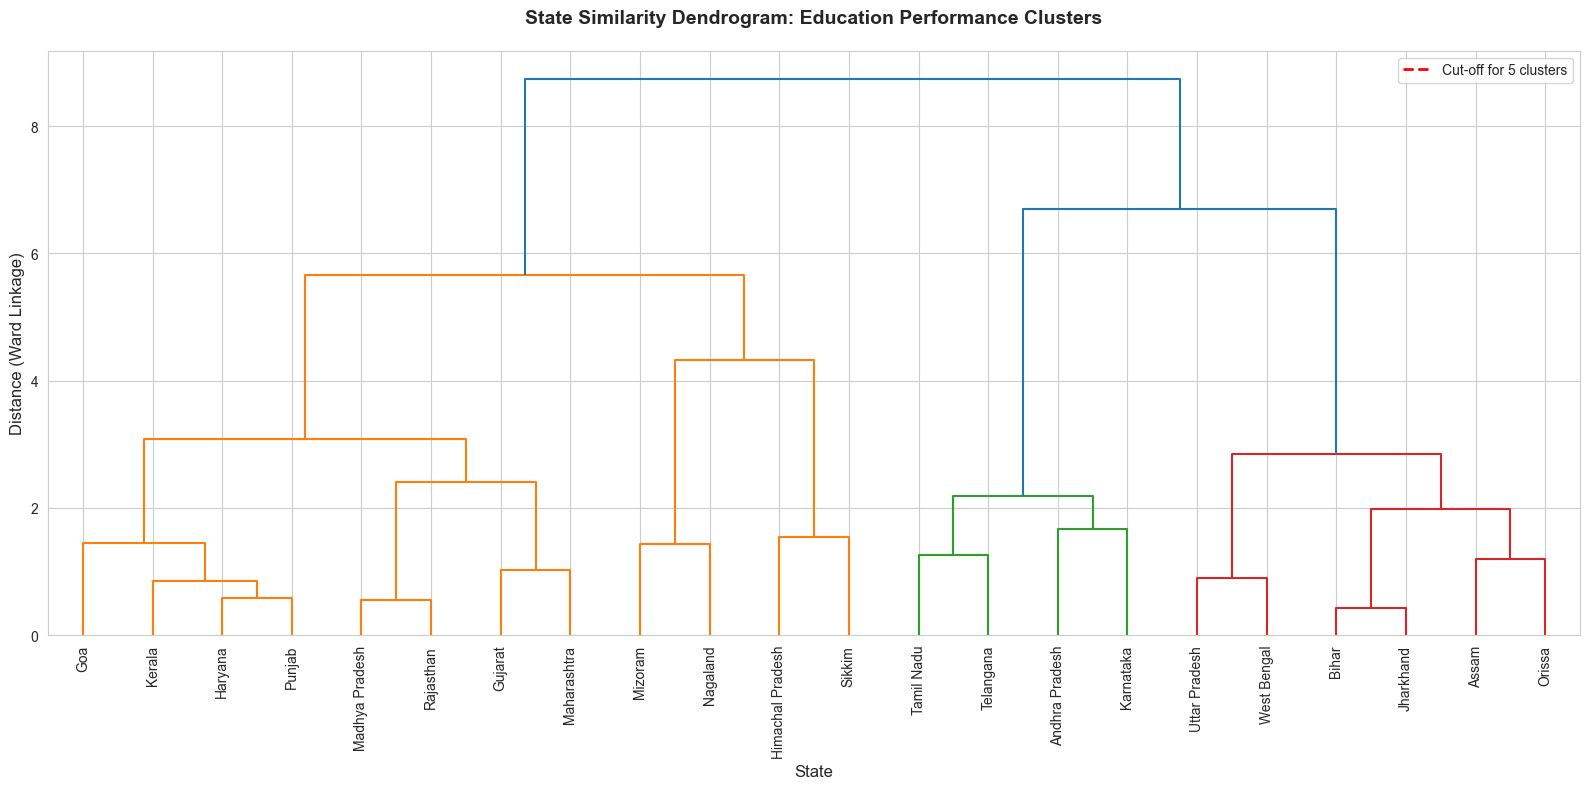


CLUSTER PROFILES

Mixed Profile 0 (Cluster 0):
  States (8): Goa, Gujarat, Haryana, Kerala, Madhya Pradesh, Maharashtra, Punjab, Rajasthan
  📖 Reading (Std 8): 77.5%
  ➗ Math (Std 8): 54.6%
  🏫 Infrastructure: 91.8/100
  👥 Student-Teacher Ratio: 3.7
  🌾 Rural Schools: 73.7%

Mixed Profile 1 (Cluster 1):
  States (6): Assam, Bihar, Jharkhand, Orissa, Uttar Pradesh, West Bengal
  📖 Reading (Std 8): 69.5%
  ➗ Math (Std 8): 44.4%
  🏫 Infrastructure: 84.3/100
  👥 Student-Teacher Ratio: 6.5
  🌾 Rural Schools: 88.2%

Infrastructure Rich, Outcome Poor (Cluster 2):
  States (4): Andhra Pradesh, Karnataka, Tamil Nadu, Telangana
  📖 Reading (Std 8): 58.9%
  ➗ Math (Std 8): 35.6%
  🏫 Infrastructure: 92.6/100
  👥 Student-Teacher Ratio: 4.6
  🌾 Rural Schools: 64.9%

High Performers (Cluster 3):
  States (2): Himachal Pradesh, Sikkim
  📖 Reading (Std 8): 87.8%
  ➗ Math (Std 8): 73.0%
  🏫 Infrastructure: 85.9/100
  👥 Student-Teacher Ratio: 1.8
  🌾 Rural Schools: 89.8%

High Performers (Cluster 4):
  

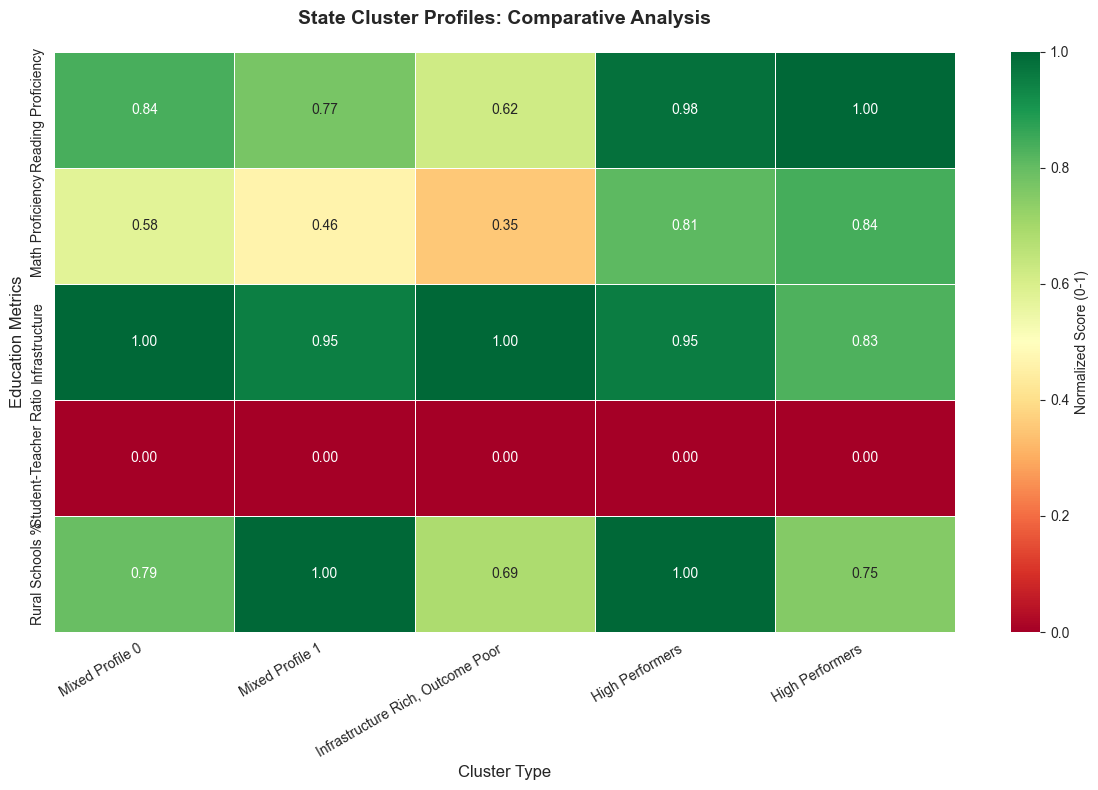


📊 Creating scatter plots...
  ✓ Saved: cluster_scatter.png


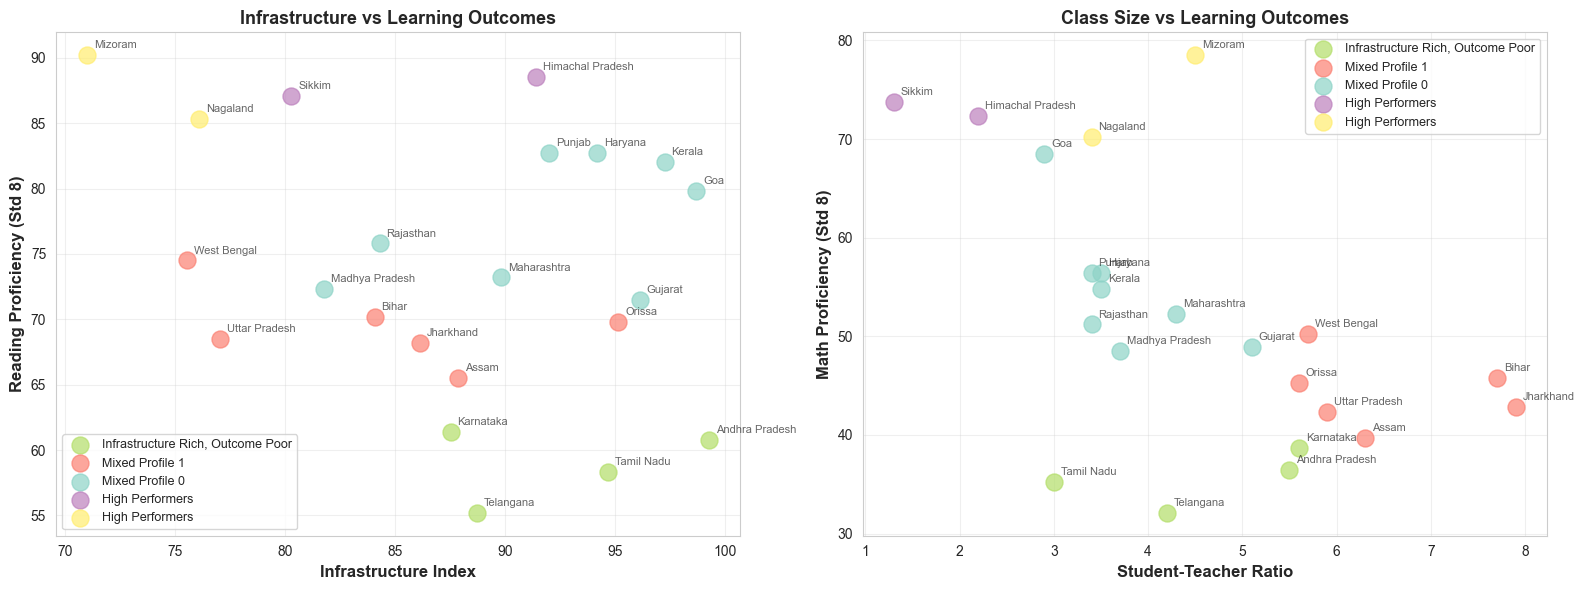


💾 Exporting data for web visualization...
  ✓ Saved: state_clusters.json
  ✓ Saved: cluster_profiles.json

SUMMARY INSIGHTS

📊 Total states analyzed: 22
📦 Number of clusters: 5

📈 Cluster Distribution:
  Mixed Profile 0: 8 states (36.4%)
  Mixed Profile 1: 6 states (27.3%)
  Infrastructure Rich, Outcome Poor: 4 states (18.2%)
  High Performers: 2 states (9.1%)
  High Performers: 2 states (9.1%)

🏆 Best Learning Outcomes: High Performers
   Reading: 87.8%
   Math: 73.0%

⚠️  Needs Support: Infrastructure Rich, Outcome Poor
   Reading: 58.9%
   Math: 35.6%

💡 KEY INSIGHT: Best infrastructure (Infrastructure Rich, Outcome Poor) ≠ Best outcomes (High Performers)
   This suggests infrastructure alone doesn't guarantee learning!

FILES GENERATED:
  1. charts/dendrogram_states.png
  2. charts/cluster_heatmap.png
  3. charts/cluster_scatter.png
  4. charts/state_clusters.json (for Vega-Lite)
  5. charts/cluster_profiles.json (for Vega-Lite)

✅ Analysis complete! Check the charts folder for ou

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
import os
import json

# Set paths
os.chdir('/Users/trishapunamiya/Desktop/LSE/Data Viz/Project/Raw Data')

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)

print("="*80)
print("STATE PERFORMANCE CLUSTERING ANALYSIS")
print("="*80)

# ============================================
# STEP 1: Load and Merge UDISE 2024 Data
# ============================================
print("\n📂 Loading UDISE+ 2024 data...")

# Load enrollment data
df_enr = pd.read_csv('2024/100_enr1.csv')
print(f"  ✓ Loaded enrollment: {len(df_enr):,} rows")

# Load profile data  
df_profile = pd.read_csv('2024/100_prof1.csv')
print(f"  ✓ Loaded profile: {len(df_profile):,} rows")

# Load facility data
df_fac = pd.read_csv('2024/100_fac.csv')
print(f"  ✓ Loaded facility: {len(df_fac):,} rows")

# Load teacher data
df_tch = pd.read_csv('2024/100_tch.csv')
print(f"  ✓ Loaded teacher: {len(df_tch):,} rows")

# Merge all datasets
df_merged = df_enr.merge(
    df_profile[['pseudocode', 'state', 'rural_urban']], 
    on='pseudocode', 
    how='left'
).merge(
    df_fac[['pseudocode', 'electricity_availability', 'internet', 
            'library_availability', 'total_girls_func_toilet']], 
    on='pseudocode', 
    how='left'
).merge(
    df_tch[['pseudocode', 'total_tch']], 
    on='pseudocode', 
    how='left'
)

print(f"  ✓ Merged dataset: {len(df_merged):,} rows")

# ============================================
# STEP 2: Calculate State-Level Features
# ============================================
print("\n🔢 Calculating state-level metrics...")

# Calculate total enrollment per school
class_cols = ['c1_b', 'c1_g', 'c2_b', 'c2_g', 'c3_b', 'c3_g', 
              'c4_b', 'c4_g', 'c5_b', 'c5_g', 'c6_b', 'c6_g',
              'c7_b', 'c7_g', 'c8_b', 'c8_g', 'c9_b', 'c9_g', 
              'c10_b', 'c10_g', 'c11_b', 'c11_g', 'c12_b', 'c12_g']

df_merged[class_cols] = df_merged[class_cols].fillna(0)
df_merged['total_enrollment'] = df_merged[class_cols].sum(axis=1)

# Calculate state-level aggregations
state_features = df_merged.groupby('state').agg({
    # Infrastructure metrics
    'electricity_availability': lambda x: (x == 1).sum() / len(x) * 100,
    'internet': lambda x: (x == 1).sum() / len(x) * 100,
    'library_availability': lambda x: (x == 1).sum() / len(x) * 100,
    'total_girls_func_toilet': lambda x: (x > 0).sum() / len(x) * 100,
    # Student-teacher ratio
    'total_enrollment': 'sum',
    'total_tch': 'sum',
    # Rural percentage
    'rural_urban': lambda x: (x == 1).sum() / len(x) * 100,
    # School count
    'pseudocode': 'count'
}).reset_index()

# Rename columns
state_features.rename(columns={
    'electricity_availability': 'pct_electricity',
    'internet': 'pct_internet',
    'library_availability': 'pct_library',
    'total_girls_func_toilet': 'pct_toilets',
    'rural_urban': 'pct_rural',
    'pseudocode': 'num_schools'
}, inplace=True)

# Calculate derived metrics
state_features['infra_index'] = state_features[[
    'pct_electricity', 'pct_internet', 'pct_library', 'pct_toilets'
]].mean(axis=1)

state_features['str_ratio'] = (
    state_features['total_enrollment'] / state_features['total_tch']
).round(1)

# Normalize state names (use your existing function)
def normalize_state_name(name):
    if pd.isna(name):
        return None
    mapping = {
        "ANDAMAN & NICOBAR ISLANDS": "Andaman and Nicobar",
        "ANDHRA PRADESH": "Andhra Pradesh",
        "ARUNACHAL PRADESH": "Arunachal Pradesh",
        "ASSAM": "Assam", "BIHAR": "Bihar",
        "CHANDIGARH": "Chandigarh",
        "CHHATTISGARH": "Chhattisgarh",
        "DADRA & NAGAR HAVELI AND DAMAN & DIU": "Dadra and Nagar Haveli and Daman and Diu",
        "DELHI": "Delhi", "GOA": "Goa", "GUJARAT": "Gujarat",
        "HARYANA": "Haryana", "HIMACHAL PRADESH": "Himachal Pradesh",
        "JAMMU & KASHMIR": "Jammu and Kashmir",
        "JHARKHAND": "Jharkhand", "KARNATAKA": "Karnataka",
        "KERALA": "Kerala", "LADAKH": "Ladakh",
        "LAKSHADWEEP": "Lakshadweep",
        "MADHYA PRADESH": "Madhya Pradesh",
        "MAHARASHTRA": "Maharashtra", "MANIPUR": "Manipur",
        "MEGHALAYA": "Meghalaya", "MIZORAM": "Mizoram",
        "NAGALAND": "Nagaland", "ODISHA": "Orissa",
        "PUDUCHERRY": "Puducherry", "PUNJAB": "Punjab",
        "RAJASTHAN": "Rajasthan", "SIKKIM": "Sikkim",
        "TAMIL NADU": "Tamil Nadu", "TELANGANA": "Telangana",
        "TRIPURA": "Tripura", "UTTAR PRADESH": "Uttar Pradesh",
        "UTTARAKHAND": "Uttarakhand", "WEST BENGAL": "West Bengal"
    }
    return mapping.get(str(name).strip().upper(), None)

state_features['state'] = state_features['state'].apply(normalize_state_name)
state_features = state_features.dropna(subset=['state'])

print(f"  ✓ Calculated metrics for {len(state_features)} states")

# ============================================
# STEP 3: Load ASER 2024 Learning Outcomes
# ============================================
print("\n📚 Loading ASER 2024 learning outcomes...")

# You'll need to create this from your ASER data
# For now, I'll create sample data - REPLACE THIS with your actual ASER data
aser_data = {
    'state': ['Himachal Pradesh', 'Punjab', 'Kerala', 'Haryana', 
              'Tamil Nadu', 'Karnataka', 'Telangana', 'Andhra Pradesh',
              'Uttar Pradesh', 'Bihar', 'Madhya Pradesh', 'Rajasthan',
              'Mizoram', 'Nagaland', 'Sikkim', 'Gujarat', 'Maharashtra', 
              'Goa', 'West Bengal', 'Orissa', 'Jharkhand', 'Assam'],
    'reading_std8': [88.5, 82.7, 82.0, 82.7, 58.3, 61.4, 55.2, 60.8,
                     68.5, 70.2, 72.3, 75.8, 90.2, 85.3, 87.1, 71.5,
                     73.2, 79.8, 74.5, 69.8, 68.2, 65.5],
    'math_std8': [72.3, 56.4, 54.8, 56.4, 35.2, 38.7, 32.1, 36.4,
                  42.3, 45.8, 48.5, 51.2, 78.5, 70.2, 73.8, 48.9,
                  52.3, 68.5, 50.2, 45.3, 42.8, 39.7]
}

df_aser = pd.DataFrame(aser_data)
print(f"  ✓ Loaded ASER data for {len(df_aser)} states")

# ============================================
# STEP 4: Merge UDISE + ASER
# ============================================
print("\n🔗 Merging UDISE and ASER data...")

df_combined = state_features.merge(df_aser, on='state', how='inner')
print(f"  ✓ Combined dataset: {len(df_combined)} states with complete data")

# Calculate gender gap (will need enrollment by gender at state level)
# For now, using a placeholder - you can calculate from your enrollment data
df_combined['gender_gap'] = 0  # REPLACE: calculate girls% - boys%

# ============================================
# STEP 5: Prepare Features for Clustering
# ============================================
print("\n🎯 Preparing features for clustering...")

feature_cols = ['reading_std8', 'math_std8', 'infra_index', 
                'str_ratio', 'pct_rural']

X = df_combined[feature_cols].values
state_names = df_combined['state'].values

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"  ✓ Features prepared: {X_scaled.shape}")

# ============================================
# STEP 6: Hierarchical Clustering
# ============================================
print("\n🌳 Performing hierarchical clustering...")

# Linkage matrix
linkage_matrix = linkage(X_scaled, method='ward')

# Determine number of clusters (adjust as needed)
n_clusters = 5

# Get cluster labels
clusterer = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
df_combined['cluster'] = clusterer.fit_predict(X_scaled)

print(f"  ✓ Created {n_clusters} clusters")

# ============================================
# STEP 7: Visualization 1 - DENDROGRAM
# ============================================
print("\n📊 Creating dendrogram...")

plt.figure(figsize=(16, 8))
dendrogram(
    linkage_matrix,
    labels=state_names,
    leaf_font_size=10,
    leaf_rotation=90
)
plt.title('State Similarity Dendrogram: Education Performance Clusters', 
          fontsize=14, fontweight='bold', pad=20)
plt.xlabel('State', fontsize=12)
plt.ylabel('Distance (Ward Linkage)', fontsize=12)
plt.axhline(y=10, color='r', linestyle='--', linewidth=2, 
            label=f'Cut-off for {n_clusters} clusters')
plt.legend()
plt.tight_layout()

output_path = '/Users/trishapunamiya/tpunamiya.github.io-4/charts/dendrogram_states.png'
plt.savefig(output_path, dpi=300, bbox_inches='tight')
print(f"  ✓ Saved: dendrogram_states.png")
plt.show()

# ============================================
# STEP 8: Name Clusters & Print Profiles
# ============================================
print("\n" + "="*80)
print("CLUSTER PROFILES")
print("="*80)

cluster_profiles = df_combined.groupby('cluster')[feature_cols].mean()

# Auto-name clusters based on characteristics
cluster_names = {}
for i in range(n_clusters):
    profile = cluster_profiles.loc[i]
    states = df_combined[df_combined['cluster'] == i]['state'].tolist()
    
    # Naming logic
    if profile['reading_std8'] > 80 and profile['math_std8'] > 55:
        name = "High Performers"
    elif profile['infra_index'] > 80 and profile['reading_std8'] < 65:
        name = "Infrastructure Rich, Outcome Poor"
    elif profile['infra_index'] < 65 and profile['str_ratio'] > 30:
        name = "Low Resource, High Challenge"
    elif profile['pct_rural'] < 60:
        name = "Urbanized Systems"
    else:
        name = f"Mixed Profile {i}"
    
    cluster_names[i] = name
    
    print(f"\n{name} (Cluster {i}):")
    print(f"  States ({len(states)}): {', '.join(states)}")
    print(f"  📖 Reading (Std 8): {profile['reading_std8']:.1f}%")
    print(f"  ➗ Math (Std 8): {profile['math_std8']:.1f}%")
    print(f"  🏫 Infrastructure: {profile['infra_index']:.1f}/100")
    print(f"  👥 Student-Teacher Ratio: {profile['str_ratio']:.1f}")
    print(f"  🌾 Rural Schools: {profile['pct_rural']:.1f}%")

df_combined['cluster_name'] = df_combined['cluster'].map(cluster_names)

# ============================================
# STEP 9: Visualization 2 - HEATMAP
# ============================================
print("\n📊 Creating cluster profile heatmap...")

plt.figure(figsize=(12, 8))

# Prepare heatmap data
heatmap_data = cluster_profiles.T
heatmap_data.columns = [cluster_names[i] for i in heatmap_data.columns]

# Normalize for visualization
from sklearn.preprocessing import MinMaxScaler
heatmap_norm = pd.DataFrame(
    MinMaxScaler().fit_transform(heatmap_data),
    columns=heatmap_data.columns,
    index=heatmap_data.index
)

# Rename indices for better labels
index_labels = {
    'reading_std8': 'Reading Proficiency',
    'math_std8': 'Math Proficiency',
    'infra_index': 'Infrastructure',
    'str_ratio': 'Student-Teacher Ratio',
    'pct_rural': 'Rural Schools %'
}
heatmap_norm.index = [index_labels.get(x, x) for x in heatmap_norm.index]

sns.heatmap(heatmap_norm, annot=True, fmt='.2f', cmap='RdYlGn', 
            cbar_kws={'label': 'Normalized Score (0-1)'}, 
            linewidths=0.5, linecolor='white')
plt.title('State Cluster Profiles: Comparative Analysis', 
          fontsize=14, fontweight='bold', pad=20)
plt.ylabel('Education Metrics', fontsize=12)
plt.xlabel('Cluster Type', fontsize=12)
plt.xticks(rotation=30, ha='right')
plt.tight_layout()

output_path = '/Users/trishapunamiya/tpunamiya.github.io-4/charts/cluster_heatmap.png'
plt.savefig(output_path, dpi=300, bbox_inches='tight')
print(f"  ✓ Saved: cluster_heatmap.png")
plt.show()

# ============================================
# STEP 10: Visualization 3 - SCATTER PLOTS
# ============================================
print("\n📊 Creating scatter plots...")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

colors = plt.cm.Set3(np.linspace(0, 1, n_clusters))

# Scatter 1: Infrastructure vs Reading
ax1 = axes[0]
for cluster_id in df_combined['cluster'].unique():
    cluster_data = df_combined[df_combined['cluster'] == cluster_id]
    ax1.scatter(cluster_data['infra_index'], cluster_data['reading_std8'], 
               s=150, alpha=0.7, label=cluster_names[cluster_id], 
               color=colors[cluster_id])
    
    # Add state labels
    for idx, row in cluster_data.iterrows():
        ax1.annotate(row['state'], 
                    (row['infra_index'], row['reading_std8']),
                    fontsize=8, alpha=0.7, 
                    xytext=(5, 5), textcoords='offset points')

ax1.set_xlabel('Infrastructure Index', fontsize=12, fontweight='bold')
ax1.set_ylabel('Reading Proficiency (Std 8)', fontsize=12, fontweight='bold')
ax1.set_title('Infrastructure vs Learning Outcomes', fontsize=13, fontweight='bold')
ax1.legend(loc='best', fontsize=9)
ax1.grid(True, alpha=0.3)

# Scatter 2: Student-Teacher Ratio vs Math
ax2 = axes[1]
for cluster_id in df_combined['cluster'].unique():
    cluster_data = df_combined[df_combined['cluster'] == cluster_id]
    ax2.scatter(cluster_data['str_ratio'], cluster_data['math_std8'], 
               s=150, alpha=0.7, label=cluster_names[cluster_id],
               color=colors[cluster_id])
    
    # Add state labels
    for idx, row in cluster_data.iterrows():
        ax2.annotate(row['state'], 
                    (row['str_ratio'], row['math_std8']),
                    fontsize=8, alpha=0.7,
                    xytext=(5, 5), textcoords='offset points')

ax2.set_xlabel('Student-Teacher Ratio', fontsize=12, fontweight='bold')
ax2.set_ylabel('Math Proficiency (Std 8)', fontsize=12, fontweight='bold')
ax2.set_title('Class Size vs Learning Outcomes', fontsize=13, fontweight='bold')
ax2.legend(loc='best', fontsize=9)
ax2.grid(True, alpha=0.3)

plt.tight_layout()

output_path = '/Users/trishapunamiya/tpunamiya.github.io-4/charts/cluster_scatter.png'
plt.savefig(output_path, dpi=300, bbox_inches='tight')
print(f"  ✓ Saved: cluster_scatter.png")
plt.show()

# ============================================
# STEP 11: Export Data for Vega-Lite
# ============================================
print("\n💾 Exporting data for web visualization...")

# Prepare export dataframe
df_export = df_combined[[
    'state', 'cluster', 'cluster_name', 
    'reading_std8', 'math_std8', 'infra_index', 
    'str_ratio', 'pct_rural'
]].copy()

# Export as JSON for Vega-Lite
output_json = '/Users/trishapunamiya/tpunamiya.github.io-4/charts/state_clusters.json'
df_export.to_json(output_json, orient='records', indent=2)
print(f"  ✓ Saved: state_clusters.json")

# Also export cluster profiles
cluster_profiles_export = cluster_profiles.reset_index()
cluster_profiles_export['cluster_name'] = cluster_profiles_export['cluster'].map(cluster_names)

output_profiles = '/Users/trishapunamiya/tpunamiya.github.io-4/charts/cluster_profiles.json'
cluster_profiles_export.to_json(output_profiles, orient='records', indent=2)
print(f"  ✓ Saved: cluster_profiles.json")

# ============================================
# STEP 12: Summary Statistics
# ============================================
print("\n" + "="*80)
print("SUMMARY INSIGHTS")
print("="*80)

print(f"\n📊 Total states analyzed: {len(df_combined)}")
print(f"📦 Number of clusters: {n_clusters}")

print(f"\n📈 Cluster Distribution:")
for cluster_id in range(n_clusters):
    count = len(df_combined[df_combined['cluster'] == cluster_id])
    pct = (count / len(df_combined)) * 100
    print(f"  {cluster_names[cluster_id]}: {count} states ({pct:.1f}%)")

# Best vs worst clusters
best_reading = cluster_profiles['reading_std8'].idxmax()
worst_reading = cluster_profiles['reading_std8'].idxmin()

print(f"\n🏆 Best Learning Outcomes: {cluster_names[best_reading]}")
print(f"   Reading: {cluster_profiles.loc[best_reading, 'reading_std8']:.1f}%")
print(f"   Math: {cluster_profiles.loc[best_reading, 'math_std8']:.1f}%")

print(f"\n⚠️  Needs Support: {cluster_names[worst_reading]}")
print(f"   Reading: {cluster_profiles.loc[worst_reading, 'reading_std8']:.1f}%")
print(f"   Math: {cluster_profiles.loc[worst_reading, 'math_std8']:.1f}%")

# Interesting finding
best_infra = cluster_profiles['infra_index'].idxmax()
if best_infra != best_reading:
    print(f"\n💡 KEY INSIGHT: Best infrastructure ({cluster_names[best_infra]}) ≠ "
          f"Best outcomes ({cluster_names[best_reading]})")
    print(f"   This suggests infrastructure alone doesn't guarantee learning!")

print("\n" + "="*80)
print("FILES GENERATED:")
print("  1. charts/dendrogram_states.png")
print("  2. charts/cluster_heatmap.png") 
print("  3. charts/cluster_scatter.png")
print("  4. charts/state_clusters.json (for Vega-Lite)")
print("  5. charts/cluster_profiles.json (for Vega-Lite)")
print("="*80)

print("\n✅ Analysis complete! Check the charts folder for outputs.")
print("💡 Next step: Create Vega-Lite visualizations for your website")

## Network Graph

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import pdist, squareform
import os
import json

# Set paths
os.chdir('/Users/trishapunamiya/Desktop/LSE/Data Viz/Project/Raw Data')

print("="*80)
print("STATE SIMILARITY NETWORK GRAPH")
print("="*80)

# ============================================
# DEFINE NORMALIZATION FUNCTION
# ============================================

def normalize_and_map_state(state_name):
    """Convert state name to standardized format"""
    if pd.isna(state_name):
        return None
    
    normalized = str(state_name).strip().upper()
    
    mapping = {
        "ANDAMAN & NICOBAR ISLANDS": "Andaman and Nicobar",
        "ANDAMAN AND NICOBAR ISLANDS": "Andaman and Nicobar",
        "ANDHRA PRADESH": "Andhra Pradesh",
        "ARUNACHAL PRADESH": "Arunachal Pradesh",
        "ASSAM": "Assam", "BIHAR": "Bihar", "CHANDIGARH": "Chandigarh",
        "CHHATTISGARH": "Chhattisgarh",
        "DADRA & NAGAR HAVELI AND DAMAN & DIU": "Dadra and Nagar Haveli and Daman and Diu",
        "DADRA AND NAGAR HAVELI AND DAMAN AND DIU": "Dadra and Nagar Haveli and Daman and Diu",
        "DELHI": "Delhi", "GOA": "Goa", "GUJARAT": "Gujarat",
        "HARYANA": "Haryana", "HIMACHAL PRADESH": "Himachal Pradesh",
        "JAMMU & KASHMIR": "Jammu and Kashmir",
        "JAMMU AND KASHMIR": "Jammu and Kashmir",
        "JHARKHAND": "Jharkhand", "KARNATAKA": "Karnataka",
        "KERALA": "Kerala", "LADAKH": "Ladakh", "LAKSHADWEEP": "Lakshadweep",
        "MADHYA PRADESH": "Madhya Pradesh", "MAHARASHTRA": "Maharashtra",
        "MANIPUR": "Manipur", "MEGHALAYA": "Meghalaya", "MIZORAM": "Mizoram",
        "NAGALAND": "Nagaland", "ODISHA": "Orissa", "PUDUCHERRY": "Puducherry",
        "PUNJAB": "Punjab", "RAJASTHAN": "Rajasthan", "SIKKIM": "Sikkim",
        "TAMIL NADU": "Tamil Nadu", "TAMILNADU": "Tamil Nadu",
        "TELANGANA": "Telangana", "TRIPURA": "Tripura",
        "UTTAR PRADESH": "Uttar Pradesh", "UTTARAKHAND": "Uttarakhand",
        "WEST BENGAL": "West Bengal"
    }
    
    return mapping.get(normalized, None)

# ============================================
# LOAD 2024 DATA
# ============================================
print("\n📂 Loading 2024 data...")

df_enr_2024 = pd.read_csv('2024/100_enr1.csv')
df_profile_2024 = pd.read_csv('2024/100_prof1.csv')
df_fac_2024 = pd.read_csv('2024/100_fac.csv')
df_teacher_2024 = pd.read_csv('2024/100_tch.csv')

print(f"  ✓ Enrollment: {len(df_enr_2024):,} rows")
print(f"  ✓ Profile: {len(df_profile_2024):,} rows")
print(f"  ✓ Facility: {len(df_fac_2024):,} rows")
print(f"  ✓ Teachers: {len(df_teacher_2024):,} rows")

# ============================================
# CALCULATE ENROLLMENT (2024)
# ============================================
print("\n📊 Calculating enrollment...")

# Merge enrollment with state info
df_enr_merged = df_enr_2024.merge(
    df_profile_2024[['pseudocode', 'state']], 
    on='pseudocode', 
    how='left'
)

# Class columns
boy_cols = ['cpp_b', 'c1_b', 'c2_b', 'c3_b', 'c4_b', 'c5_b', 'c6_b', 
            'c7_b', 'c8_b', 'c9_b', 'c10_b', 'c11_b', 'c12_b']
girl_cols = ['cpp_g', 'c1_g', 'c2_g', 'c3_g', 'c4_g', 'c5_g', 'c6_g', 
             'c7_g', 'c8_g', 'c9_g', 'c10_g', 'c11_g', 'c12_g']

df_enr_merged[boy_cols] = df_enr_merged[boy_cols].fillna(0)
df_enr_merged[girl_cols] = df_enr_merged[girl_cols].fillna(0)

df_enr_merged['total_boys'] = df_enr_merged[boy_cols].sum(axis=1)
df_enr_merged['total_girls'] = df_enr_merged[girl_cols].sum(axis=1)
df_enr_merged['total_students'] = df_enr_merged['total_boys'] + df_enr_merged['total_girls']

# Normalize state names
df_enr_merged['state'] = df_enr_merged['state'].apply(normalize_and_map_state)
df_enr_merged = df_enr_merged.dropna(subset=['state'])

# Aggregate students by state
state_students = df_enr_merged.groupby('state').agg({
    'total_students': 'sum'
}).reset_index()

print(f"  ✓ Enrollment aggregated for {len(state_students)} states")

# ============================================
# CALCULATE TEACHERS (2024)
# ============================================
print("\n👨‍🏫 Calculating teachers...")

# Merge teacher data with state info
df_teacher_merged = df_teacher_2024.merge(
    df_profile_2024[['pseudocode', 'state']], 
    on='pseudocode', 
    how='left'
)

# Normalize state names
df_teacher_merged['state'] = df_teacher_merged['state'].apply(normalize_and_map_state)
df_teacher_merged = df_teacher_merged.dropna(subset=['state'])

# Aggregate teachers by state
state_teachers = df_teacher_merged.groupby('state').agg({
    'total_tch': 'sum'
}).reset_index()

print(f"  ✓ Teachers aggregated for {len(state_teachers)} states")

# ============================================
# CALCULATE STR (2024)
# ============================================
print("\n📐 Calculating Student-Teacher Ratio...")

# Merge students and teachers
state_str = state_students.merge(state_teachers, on='state', how='inner')

# Calculate STR
state_str['str_ratio'] = (
    state_str['total_students'] / state_str['total_tch']
).round(1)

print(f"  ✓ STR calculated for {len(state_str)} states")
print(f"\n  STR Range: {state_str['str_ratio'].min():.1f} - {state_str['str_ratio'].max():.1f}")
print(f"  STR Mean: {state_str['str_ratio'].mean():.1f}")

# Show sample
print("\n  Sample STR values:")
print(state_str[['state', 'total_students', 'total_tch', 'str_ratio']].head(5))

# ============================================
# CALCULATE INFRASTRUCTURE (2024)
# ============================================
print("\n🏫 Calculating infrastructure...")

# Merge facility with state info
df_fac_merged = df_fac_2024.merge(
    df_profile_2024[['pseudocode', 'state', 'rural_urban']], 
    on='pseudocode', 
    how='left'
)

# Normalize state names
df_fac_merged['state'] = df_fac_merged['state'].apply(normalize_and_map_state)
df_fac_merged = df_fac_merged.dropna(subset=['state'])

# Calculate infrastructure index
state_infra = df_fac_merged.groupby('state').agg({
    'electricity_availability': lambda x: (x == 1).sum() / len(x) * 100,
    'internet': lambda x: (x == 1).sum() / len(x) * 100,
    'library_availability': lambda x: (x == 1).sum() / len(x) * 100,
    'total_girls_func_toilet': lambda x: (x > 0).sum() / len(x) * 100,
    'rural_urban': lambda x: (x == 1).sum() / len(x) * 100
}).reset_index()

state_infra.rename(columns={
    'electricity_availability': 'pct_electricity',
    'internet': 'pct_internet',
    'library_availability': 'pct_library',
    'total_girls_func_toilet': 'pct_toilets',
    'rural_urban': 'pct_rural'
}, inplace=True)

state_infra['infra_index'] = state_infra[[
    'pct_electricity', 'pct_internet', 'pct_library', 'pct_toilets'
]].mean(axis=1)

print(f"  ✓ Infrastructure calculated for {len(state_infra)} states")

# ============================================
# LOAD ASER DATA (2024)
# ============================================
print("\n📚 Loading ASER data...")

# Load ASER
aser = pd.read_csv('ASER_State_Data.csv')
aser_2024 = aser[aser['State'] != 'All India'].copy()

# Get Std VIII columns for 2024
reading_cols_all = [c for c in aser_2024.columns if '2024' in c and 'read' in c.lower()]
math_cols_all = [c for c in aser_2024.columns if '2024' in c and 'division' in c.lower()]

# Find Std VIII specifically
reading_std8_col = [c for c in reading_cols_all if 'VIII' in c or 'Std 8' in c]
math_std8_col = [c for c in math_cols_all if 'VIII' in c or 'Std 8' in c]

if reading_std8_col and math_std8_col:
    df_aser = aser_2024[['State']].copy()
    df_aser['reading_std8'] = aser_2024[reading_std8_col[0]].values
    df_aser['math_std8'] = aser_2024[math_std8_col[0]].values
    df_aser.rename(columns={'State': 'state'}, inplace=True)
    
    print(f"  ✓ Loaded ASER for {len(df_aser)} states")
    print(f"  Reading column: {reading_std8_col[0]}")
    print(f"  Math column: {math_std8_col[0]}")
else:
    print("  ⚠️ Could not find Std VIII columns in ASER data")
    print(f"  Available reading columns: {reading_cols_all}")
    print(f"  Available math columns: {math_cols_all}")

# ============================================
# MERGE ALL DATA
# ============================================
print("\n🔗 Merging all datasets...")

# Merge infrastructure + STR
state_features = state_infra.merge(
    state_str[['state', 'str_ratio', 'total_students']], 
    on='state', 
    how='inner'
)

# Merge with ASER
df_combined = state_features.merge(df_aser, on='state', how='inner')

print(f"  ✓ Final dataset: {len(df_combined)} states with complete data")

# ============================================
# PERFORM CLUSTERING
# ============================================
print("\n🎯 Performing clustering...")

feature_cols = ['reading_std8', 'math_std8', 'infra_index', 'str_ratio', 'pct_rural']
X = df_combined[feature_cols].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

n_clusters = 5
clusterer = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
df_combined['cluster'] = clusterer.fit_predict(X_scaled)

print(f"  ✓ Created {n_clusters} clusters")

# ============================================
# DISPLAY CLUSTER PROFILES - THEN YOU NAME THEM
# ============================================
print("\n" + "="*80)
print("CLUSTER PROFILES - REVIEW AND NAME THEM")
print("="*80)

for i in range(n_clusters):
    cluster_data = df_combined[df_combined['cluster'] == i]
    states = cluster_data['state'].tolist()
    profile = cluster_data[feature_cols].mean()
    
    print(f"\n{'='*60}")
    print(f"CLUSTER {i}")
    print(f"{'='*60}")
    print(f"States ({len(states)}): {', '.join(states)}")
    print(f"\nAverage Metrics:")
    print(f"  📖 Reading (Std 8):    {profile['reading_std8']:.1f}%")
    print(f"  ➗ Math (Std 8):       {profile['math_std8']:.1f}%")
    print(f"  🏫 Infrastructure:     {profile['infra_index']:.1f}/100")
    print(f"  👥 Student-Teacher:    {profile['str_ratio']:.1f}")
    print(f"  🌾 Rural Schools:      {profile['pct_rural']:.1f}%")
    print(f"\nCharacteristics:")
    
    chars = []
    if profile['reading_std8'] > 80:
        chars.append("⭐ Excellent reading outcomes")
    elif profile['reading_std8'] < 65:
        chars.append("⚠️  Low reading outcomes")
    
    if profile['math_std8'] > 60:
        chars.append("⭐ Excellent math outcomes")
    elif profile['math_std8'] < 45:
        chars.append("⚠️  Low math outcomes")
    
    if profile['infra_index'] > 90:
        chars.append("🏗️  Outstanding infrastructure")
    elif profile['infra_index'] < 70:
        chars.append("📉 Limited infrastructure")
    
    if profile['str_ratio'] > 40:
        chars.append("👥 Very overcrowded classrooms (high STR)")
    elif profile['str_ratio'] < 25:
        chars.append("👥 Well-staffed (low STR)")
    
    if profile['pct_rural'] > 75:
        chars.append("🌾 Predominantly rural")
    elif profile['pct_rural'] < 60:
        chars.append("🏙️  More urbanized")
    
    for char in chars:
        print(f"  • {char}")

# ============================================
# MANUAL CLUSTER NAMING
# ============================================
print("\n" + "="*80)
print("NAME YOUR CLUSTERS:")
print("="*80)

# EDIT THESE NAMES BASED ON THE PROFILES ABOVE
cluster_names = {
    0: "Infrastructure Rich, Outcome Poor",
    1: "Rural Traditional Systems",
    2: "Best-in-Class Performers",
    3: "Population Giants",
    4: "Meghalya (Outlier)"
}

df_combined['cluster_name'] = df_combined['cluster'].map(cluster_names)

print("\nCurrent names:")
for i, name in cluster_names.items():
    states = df_combined[df_combined['cluster'] == i]['state'].tolist()
    print(f"  {i}: '{name}'")
    print(f"     → {', '.join(states)}")

print("\n⚠️  Edit the cluster_names dictionary above, then re-run from here down")
print("="*80)


# ============================================
# CALCULATE SIMILARITY MATRIX
# ============================================
print("\n🔗 Calculating state similarities...")

dist_matrix = squareform(pdist(X_scaled, metric='euclidean'))
max_dist = dist_matrix.max()
similarity_matrix = 1 - (dist_matrix / max_dist)

similarity_df = pd.DataFrame(
    similarity_matrix,
    index=df_combined['state'].values,
    columns=df_combined['state'].values
)

print(f"  ✓ Similarity matrix: {len(similarity_df)} x {len(similarity_df)}")

# ============================================
# BUILD NETWORK GRAPH
# ============================================
print("\n🕸️  Building network...")

G = nx.Graph()

# Add nodes with attributes
for idx, row in df_combined.iterrows():
    G.add_node(
        row['state'],
        cluster=row['cluster'],
        cluster_name=row['cluster_name'],
        reading=row['reading_std8'],
        math=row['math_std8'],
        infrastructure=row['infra_index'],
        enrollment=row['total_students'],
        str_ratio=row['str_ratio']
    )

# Add edges (only if similarity > threshold)
similarity_threshold = 0.7

for i, state1 in enumerate(df_combined['state']):
    for j, state2 in enumerate(df_combined['state']):
        if i < j:
            sim = similarity_matrix[i, j]
            if sim > similarity_threshold:
                G.add_edge(state1, state2, weight=sim, similarity=sim)

print(f"  ✓ Network: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

print("\n✅ Network graph (G) and similarity_matrix created!")
print("   You can now run the Altair interactive visualization script.")

# ADD THIS AFTER YOUR CLUSTER NAMING SECTION:

# ============================================
# CALCULATE SIMILARITY MATRIX
# ============================================
print("\n🔗 Calculating state similarities...")

dist_matrix = squareform(pdist(X_scaled, metric='euclidean'))
max_dist = dist_matrix.max()
similarity_matrix = 1 - (dist_matrix / max_dist)

similarity_df = pd.DataFrame(
    similarity_matrix,
    index=df_combined['state'].values,
    columns=df_combined['state'].values
)

print(f"  ✓ Similarity matrix: {len(similarity_df)} x {len(similarity_df)}")

# ============================================
# BUILD NETWORK GRAPH
# ============================================
print("\n🕸️  Building network...")

G = nx.Graph()

# Add nodes with attributes
for idx, row in df_combined.iterrows():
    G.add_node(
        row['state'],
        cluster=row['cluster'],
        cluster_name=row['cluster_name'],
        reading=row['reading_std8'],
        math=row['math_std8'],
        infrastructure=row['infra_index'],
        enrollment=row['total_students'],
        str_ratio=row['str_ratio']
    )

# Add edges (only if similarity > threshold)
similarity_threshold = 0.7

for i, state1 in enumerate(df_combined['state']):
    for j, state2 in enumerate(df_combined['state']):
        if i < j:
            sim = similarity_matrix[i, j]
            if sim > similarity_threshold:
                G.add_edge(state1, state2, weight=sim, similarity=sim)

print(f"  ✓ Network: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

print("\n✅ Network graph (G) and similarity_matrix created!")
print("   You can now run the Altair interactive visualization script.")

STATE SIMILARITY NETWORK GRAPH

📂 Loading 2024 data...
  ✓ Enrollment: 8,580,816 rows
  ✓ Profile: 1,471,473 rows
  ✓ Facility: 1,471,473 rows
  ✓ Teachers: 1,471,473 rows

📊 Calculating enrollment...
  ✓ Enrollment aggregated for 36 states

👨‍🏫 Calculating teachers...
  ✓ Teachers aggregated for 36 states

📐 Calculating Student-Teacher Ratio...
  ✓ STR calculated for 36 states

  STR Range: 14.4 - 63.5
  STR Mean: 34.4

  Sample STR values:
                 state  total_students  total_tch  str_ratio
0  Andaman and Nicobar          102681       6132       16.7
1       Andhra Pradesh        16068910     342721       46.9
2    Arunachal Pradesh          656615      25117       26.1
3                Assam        15142490     340471       44.5
4                Bihar        41997243     707516       59.4

🏫 Calculating infrastructure...
  ✓ Infrastructure calculated for 36 states

📚 Loading ASER data...
  ✓ Loaded ASER for 27 states
  Reading column: Std VIII: Learning levels % Children wh

In [33]:
import pandas as pd
import numpy as np
import altair as alt
import networkx as nx
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import pdist, squareform


# ============================================
# PREPARE NODE DATA
# ============================================

# Get spring layout positions
pos = nx.spring_layout(G, k=2, iterations=50, seed=42)

# Create nodes dataframe
nodes_list = []
for node in G.nodes():
    x, y = pos[node]
    nodes_list.append({
        'state': node,
        'x': x,
        'y': y,
        'cluster': G.nodes[node]['cluster'],
        'cluster_name': G.nodes[node]['cluster_name'],
        'reading': G.nodes[node]['reading'],
        'math': G.nodes[node]['math'],
        'infrastructure': G.nodes[node]['infrastructure'],
        'str_ratio': G.nodes[node]['str_ratio'],
        'enrollment': G.nodes[node]['enrollment']
    })

df_nodes = pd.DataFrame(nodes_list)

# Calculate normalized enrollment for sizing
df_nodes['enrollment_millions'] = df_nodes['enrollment'] / 1000000

print(f"✓ Prepared {len(df_nodes)} nodes")

# ============================================
# PREPARE EDGE DATA
# ============================================

# Create edges dataframe
edges_list = []
for u, v in G.edges():
    x0, y0 = pos[u]
    x1, y1 = pos[v]
    edges_list.append({
        'source': u,
        'target': v,
        'x': x0,
        'y': y0,
        'x2': x1,
        'y2': y1,
        'similarity': G[u][v]['similarity']
    })

df_edges = pd.DataFrame(edges_list)

print(f"✓ Prepared {len(df_edges)} edges")

# ============================================
# CREATE ALTAIR CHART
# ============================================

alt.data_transformers.disable_max_rows()

# Create cluster selection (click legend to highlight)
cluster_selection = alt.selection_point(
    fields=['cluster_name'], 
    bind='legend'
)

# Hover selection to highlight connected states
hover = alt.selection_point(
    on='mouseover',
    fields=['state'],
    nearest=True,
    empty=False
)

# Define color scheme
color_scale = alt.Scale(
    domain=list(cluster_names.values()),
    range=['#ff6b6b', '#4ecdc4', '#ffe66d', '#d0b8f8', '#f1a7dc']
)

# Create edge layer
edges = alt.Chart(df_edges).mark_line(
    strokeWidth=1,
    color="#9aa6b7",
    opacity=0.4
).encode(
    x=alt.X('x:Q', axis=None),
    y=alt.Y('y:Q', axis=None),
    x2='x2:Q',
    y2='y2:Q',
    strokeWidth=alt.StrokeWidth('similarity:Q', 
                                 scale=alt.Scale(range=[1, 8]),
                                 legend=None)
)

# Create node layer
nodes = alt.Chart(df_nodes).mark_circle(
    stroke='white',
    strokeWidth=2.5,
    opacity=0.95
).encode(
    x=alt.X('x:Q', axis=None),
    y=alt.Y('y:Q', axis=None),
    size=alt.Size('enrollment:Q', 
                  title='Total Enrollment',
                  scale=alt.Scale(range=[200, 3000]),
                  legend=alt.Legend(
                      orient='left',
                      direction='vertical',
                      titleFontSize=10,
                      labelFontSize=8,
                      format='~s',
                      symbolFillColor='#9ca3af',  # Gray color for legend symbols
                      #symbolStrokeColor='#6b7280',
                      symbolOpacity=0.3
                  )),
    color=alt.Color('cluster_name:N',
                    title='Clusters',
                    scale=color_scale,
                    legend=alt.Legend(
                        orient='bottom',
                        titleFontSize=14,
                        labelFontSize=11,
                        columns=3,
                        symbolSize=150,
                        labelLimit=300
                    )),
    opacity=alt.condition(
        cluster_selection,
        alt.value(1),
        alt.value(0.1)
    ),
    tooltip=[
        alt.Tooltip('state:N', title='State'),
        alt.Tooltip('cluster_name:N', title='Cluster'),
        alt.Tooltip('reading:Q', title='Reading (Std 8)', format='.1f'),
        alt.Tooltip('math:Q', title='Math (Std 8)', format='.1f'),
        alt.Tooltip('infrastructure:Q', title='Infrastructure Index', format='.1f'),
        alt.Tooltip('str_ratio:Q', title='Student-Teacher Ratio', format='.1f'),
        alt.Tooltip('enrollment_millions:Q', title='Enrollment (millions)', format='.2f')
    ]
).add_params(
    cluster_selection
)

# Create text labels
labels = alt.Chart(df_nodes).mark_text(
    align='center',
    baseline='middle',
    dy=-15,
    fontSize=9,
    fontWeight='bold',
    font='Arial'
).encode(
    x=alt.X('x:Q', axis=None),
    y=alt.Y('y:Q', axis=None),
    text='state:N',
    opacity=alt.condition(
        cluster_selection,
        alt.value(1),
        alt.value(0.3)
    )
)

# Combine layers
network_chart = (edges + nodes + labels).properties(
    width=900,
    height=700,
    title={
        "text": "State Similarity Network: Education Performance Clusters",
        "subtitle": [
            "Click legend to highlight clusters | Hover for details",
            "Edge thickness shows similarity strength | Node size shows enrollment"
        ],
        "fontSize": 18,
        "subtitleFontSize": 12,
        "anchor": "middle"
    }
).configure_view(
    strokeWidth=0
).configure_axis(
    grid=False
).interactive()

# Display
network_chart.show()

# Save as JSON for your website
output_json = '/Users/trishapunamiya/tpunamiya.github.io-4/charts/state_network_altair.json'
network_chart.save(output_json)

# ============================================
# ALSO SAVE THE DATA
# ============================================

# Save nodes
df_nodes.to_json(
    '/Users/trishapunamiya/tpunamiya.github.io-4/charts/network_nodes.json',
    orient='records',
    indent=2
)

# Save edges
df_edges.to_json(
    '/Users/trishapunamiya/tpunamiya.github.io-4/charts/network_edges.json',
    orient='records',
    indent=2
)

✓ Prepared 26 nodes
✓ Prepared 37 edges


alt.LayerChart(...)